In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import normflows as nf
import larsflow as lf

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from sklearn.model_selection import train_test_split

print('Python', sys.version)

Python 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]


In [2]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pytorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [5]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define the model creation function
def create_model(base='gauss'):
    K = 8  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 100, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)


# Training function
def train(dataloader, model, optimizer, scheduler=None):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    print(f"Training Loss: {total_loss / len(dataloader)}")


# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Create a new model instance
model2 = create_model(base='resampled')

batch_size = 1000 
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 20
learning_rate = 0.002
min_learning_rate = 1e-6

# Optimizer and scheduler
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.9, patience=100, min_lr=min_learning_rate)

# Training loop
for epoch in tqdm(range(epochs), ncols=100):
    train(train_dataloader, model2, optimizer, scheduler)

print("Done!")

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)


  0%|                                                                        | 0/20 [01:14<?, ?it/s]


KeyboardInterrupt: 

In [8]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Enable cuDNN auto-tuner for optimized performance
torch.backends.cudnn.benchmark = True

# Define the model creation function
def create_model(base='gauss'):
    K = 8  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 100, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)


# Training function with mixed precision
def train(dataloader, model, optimizer, scaler, scheduler=None):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = -model.log_prob(batch).mean()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    print(f"Training Loss: {total_loss / len(dataloader)}")


# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new model instance
model2 = create_model(base='resampled')

batch_size = 20000 
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 20
learning_rate = 0.002
min_learning_rate = 1e-6

# Optimizer and scheduler
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, min_lr=min_learning_rate)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Training loop
for epoch in tqdm(range(epochs), ncols=100):
    train(train_dataloader, model2, optimizer, scaler, scheduler)

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)


  5%|███▏                                                           | 1/20 [02:07<40:19, 127.33s/it]

Training Loss: -1.0085126617178322


 10%|██████▎                                                        | 2/20 [04:12<37:44, 125.78s/it]

Training Loss: -1.0976858820021151


 15%|█████████▍                                                     | 3/20 [06:16<35:25, 125.02s/it]

Training Loss: -1.1037433928251266


 20%|████████████▌                                                  | 4/20 [08:20<33:19, 124.94s/it]

Training Loss: -1.1063564838469029


 20%|████████████▌                                                  | 4/20 [08:43<34:55, 130.99s/it]


KeyboardInterrupt: 

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Number of parameters in the model: 81097


  0%|                                                                        | 0/20 [00:00<?, ?it/s]

Training Loss: -0.7900582068786025


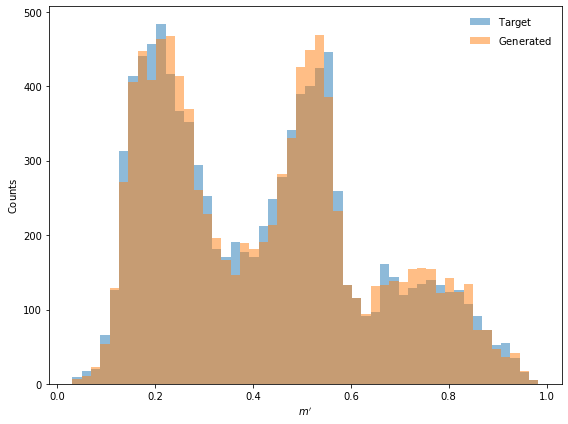

  5%|███▏                                                           | 1/20 [02:14<42:43, 134.90s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.0720381703972817


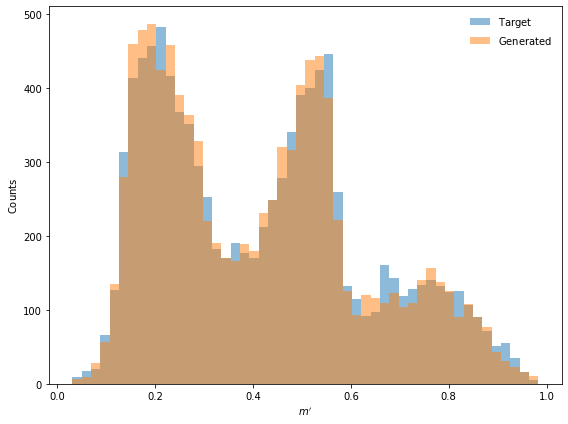

 10%|██████▎                                                        | 2/20 [04:33<41:06, 137.00s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.0833281710743905


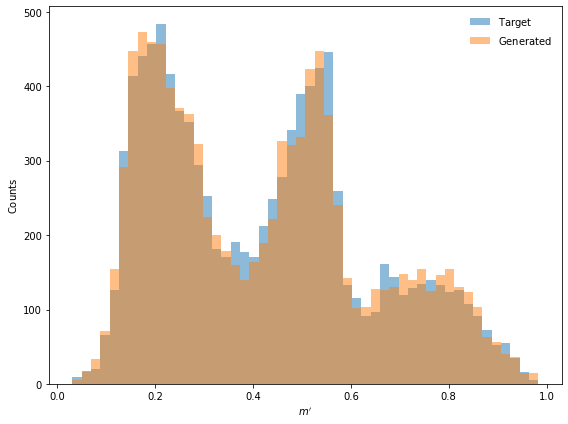

 15%|█████████▍                                                     | 3/20 [06:55<39:32, 139.57s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.0908887833356857


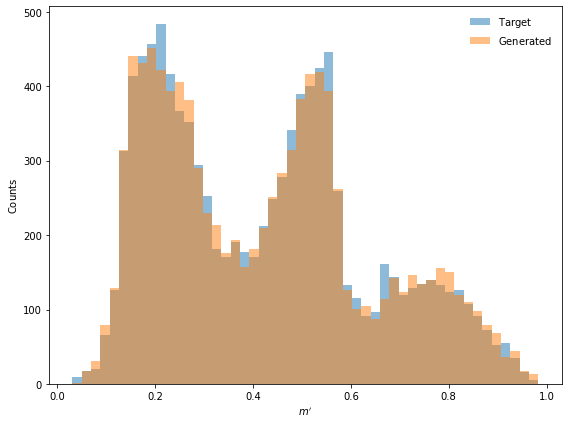

 20%|████████████▌                                                  | 4/20 [09:15<37:14, 139.66s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.0961984938383103


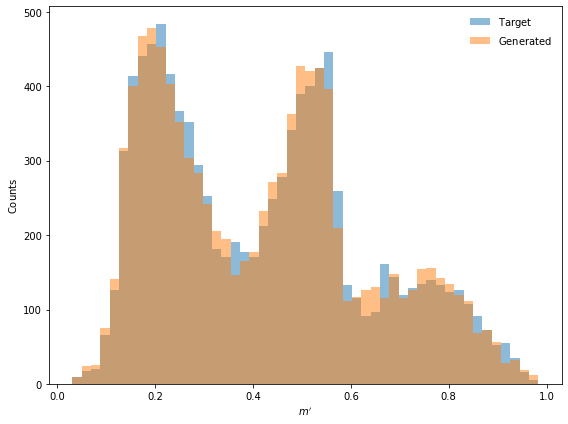

 25%|███████████████▊                                               | 5/20 [11:49<36:09, 144.62s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.0979542583227158


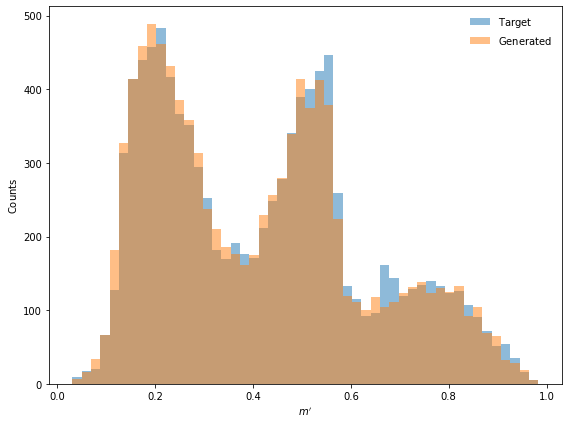

 30%|██████████████████▉                                            | 6/20 [14:29<35:01, 150.10s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1000642013549804


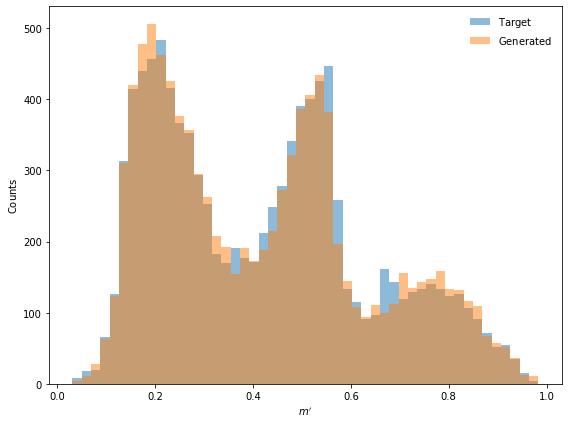

 35%|██████████████████████                                         | 7/20 [17:01<32:38, 150.69s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1018266743421554


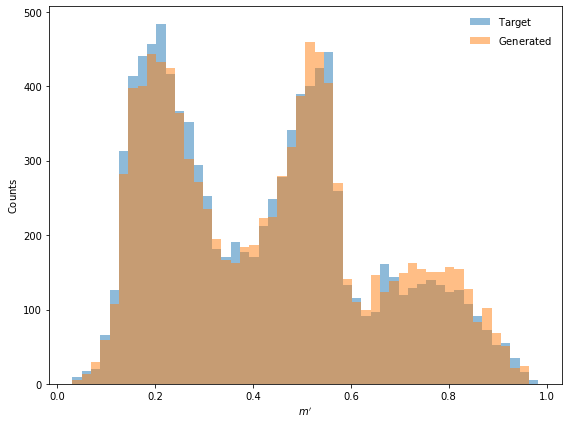

 40%|█████████████████████████▏                                     | 8/20 [22:55<43:05, 215.46s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1051236096024513


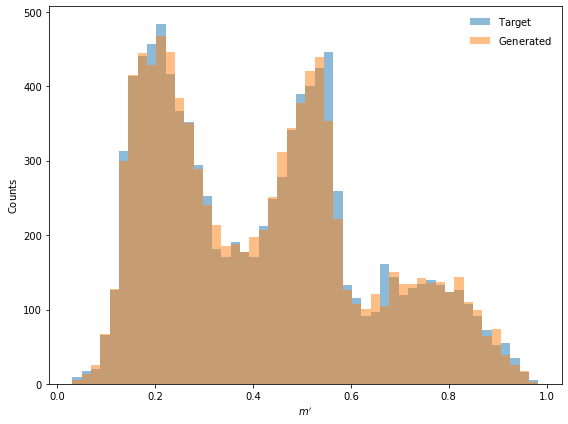

 45%|███████████████████████████▍                                 | 9/20 [40:03<1:26:00, 469.17s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1044967827200889


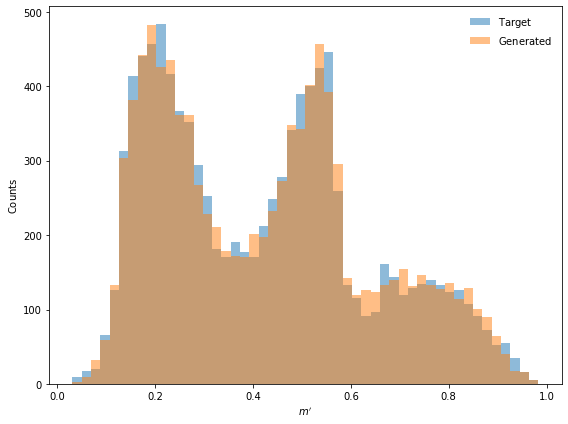

 50%|██████████████████████████████                              | 10/20 [42:18<1:01:02, 366.25s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1054742598533631


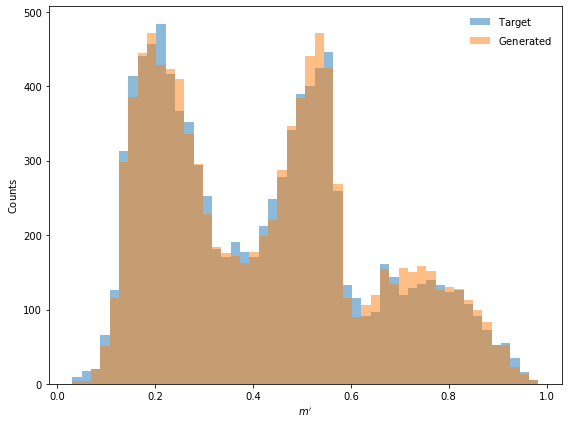

 55%|██████████████████████████████████                            | 11/20 [44:54<45:16, 301.79s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1060589161515235


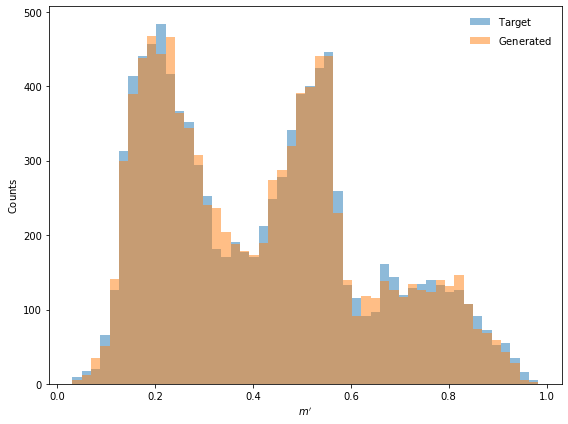

 60%|█████████████████████████████████████▏                        | 12/20 [47:47<35:00, 262.51s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1073455435037614


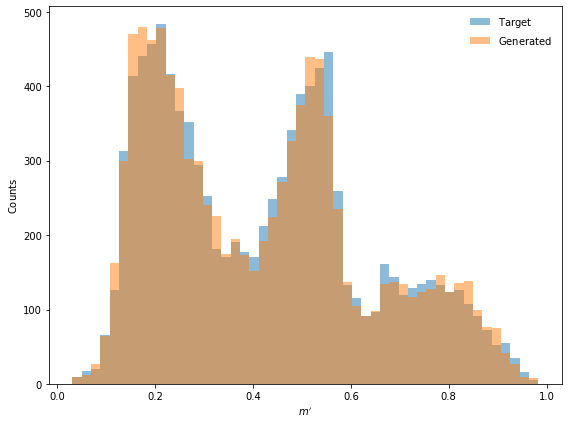

 65%|████████████████████████████████████████▎                     | 13/20 [50:14<26:33, 227.60s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1086535891890525


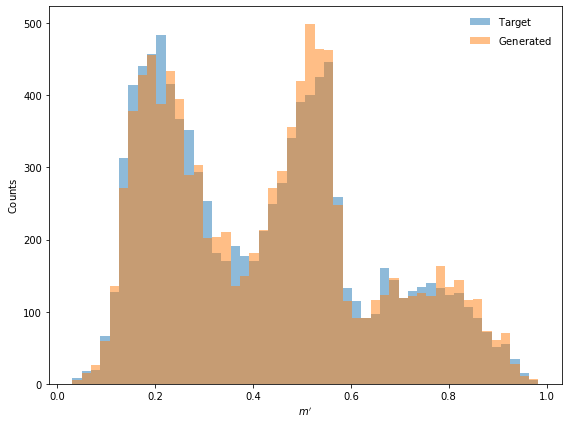

 70%|███████████████████████████████████████████▍                  | 14/20 [52:18<19:38, 196.42s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1090376299619675


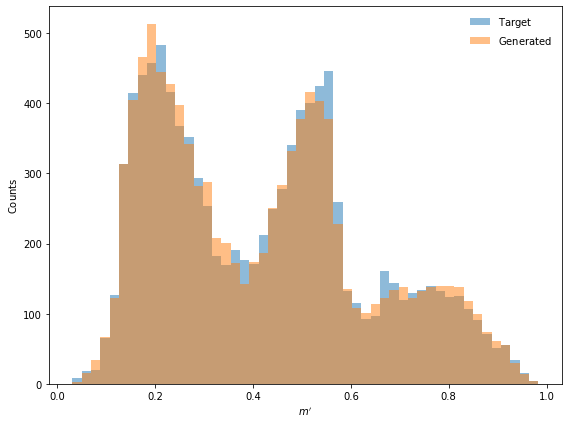

 75%|██████████████████████████████████████████████▌               | 15/20 [54:40<14:59, 179.83s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1114670982956887


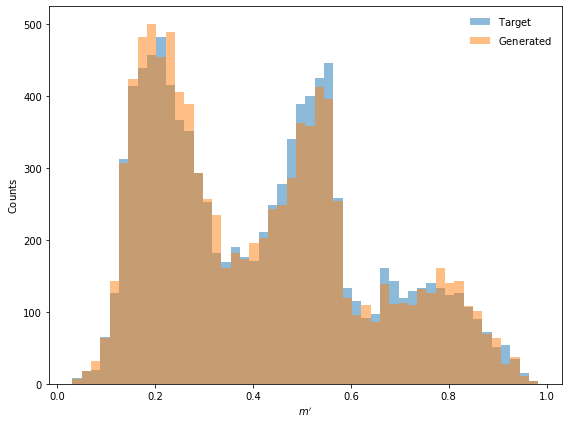

 80%|█████████████████████████████████████████████████▌            | 16/20 [57:10<11:23, 170.93s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1100000950694084


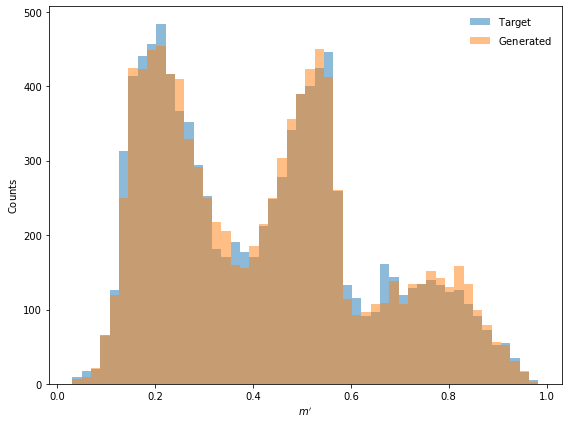

 85%|████████████████████████████████████████████████████▋         | 17/20 [59:46<08:19, 166.42s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1105503326654433


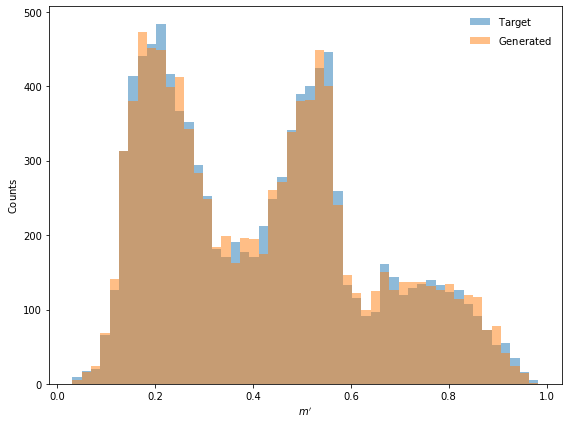

 90%|██████████████████████████████████████████████████████      | 18/20 [1:02:28<05:30, 165.17s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1116556909680366


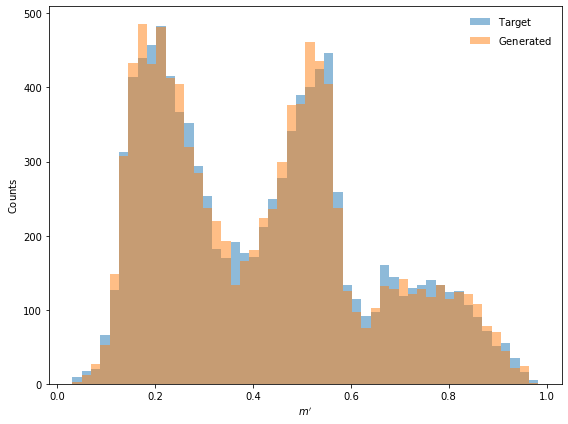

 95%|█████████████████████████████████████████████████████████   | 19/20 [1:05:10<02:44, 164.17s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1105329310894012


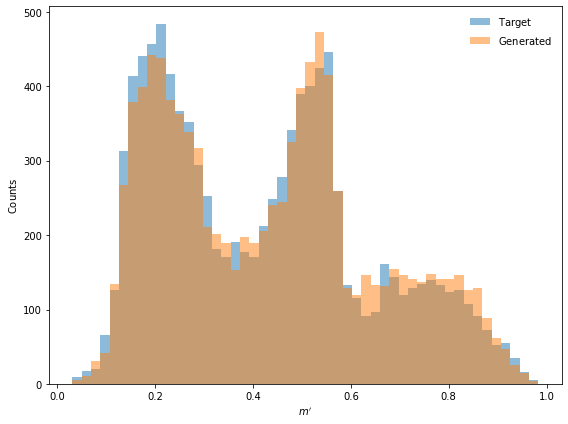

100%|████████████████████████████████████████████████████████████| 20/20 [1:07:47<00:00, 203.38s/it]


In [3]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable cuDNN auto-tuner for optimized performance
torch.backends.cudnn.benchmark = True

# Define the model creation function
def create_model(base='gauss'):
    K = 12  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 100, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)


# Training function with mixed precision and gradient accumulation
def train(dataloader, model, optimizer, scaler, scheduler=None, accumulation_steps=1):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = -model.log_prob(batch).mean()
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    print(f"Training Loss: {total_loss / len(dataloader)}")


# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new model instance
model2 = create_model(base='resampled')

# Count the number of parameters
num_params = count_parameters(model2)
print(f"Number of parameters in the model: {num_params}")

# Adjust batch size
batch_size = 20000 
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 20
learning_rate = 0.001
min_learning_rate = 1e-6
accumulation_steps = 4  # Gradient accumulation steps

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, min_lr=min_learning_rate)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Training loop with plotting
for epoch in tqdm(range(epochs), ncols=100):
    train(train_dataloader, model2, optimizer, scaler, scheduler, accumulation_steps)
    
    # Generate samples from the trained model
    model2.eval()
    with torch.no_grad():
        samples = model2.sample(10000)
        if isinstance(samples, tuple):
            samples = samples[0]  # Extract the tensor if it's a tuple
        generated_samples = samples.cpu().numpy()

    # Number of samples to visualize
    n_samples = 10000

    # Visualize
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot target distribution
    counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 50, alpha=0.5, label=r'$\mathrm{Target}$')

    # Plot generated samples
    ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

    ax.set_xlabel(r"$m'$")
    ax.set_ylabel(r'$\mathrm{Counts}$')

    ax.legend(loc='best', frameon=False)

    fig.tight_layout()
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.png', dpi=300, pad_inches=.1, bbox_inches='tight')

    plt.show()

/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Number of parameters in the model: 90617


  0%|                                                                        | 0/20 [00:00<?, ?it/s]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -0.8441727209463715


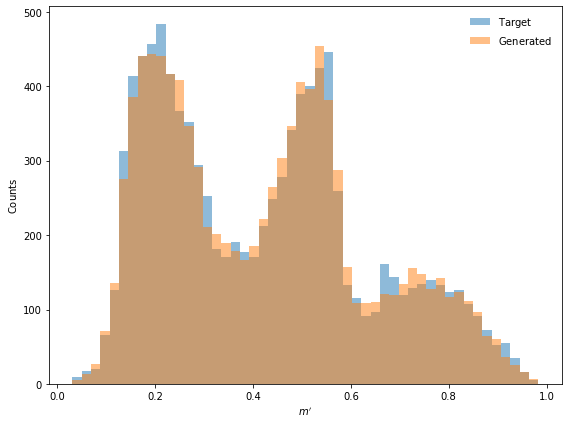

  5%|███▏                                                           | 1/20 [02:22<45:11, 142.69s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.0815433928370475


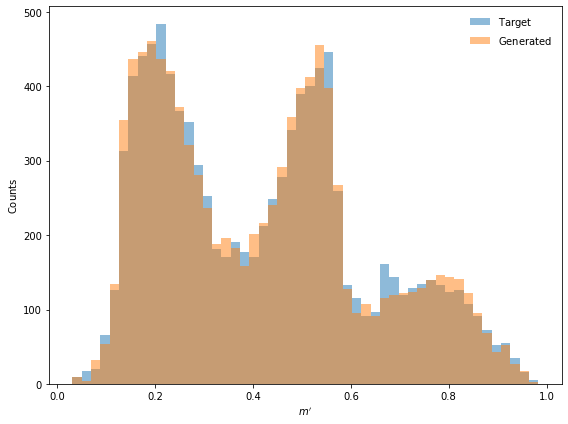

 10%|██████▎                                                        | 2/20 [04:44<42:34, 141.89s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.094539738893509


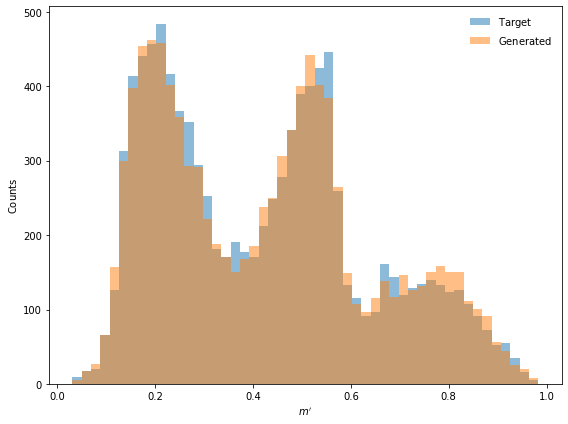

 15%|█████████▍                                                     | 3/20 [08:24<50:21, 177.74s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.099813896715641


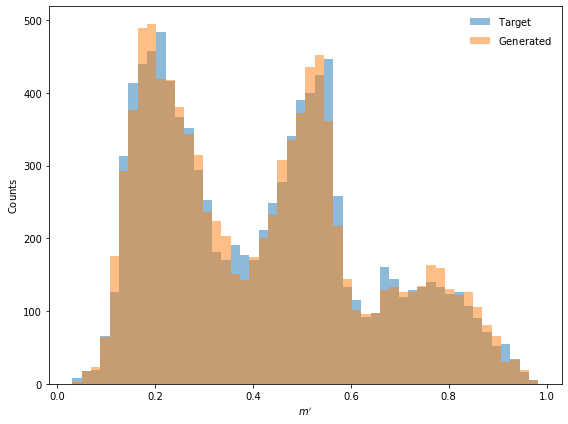

 20%|████████████▏                                                | 4/20 [15:20<1:12:26, 271.66s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1045526814460755


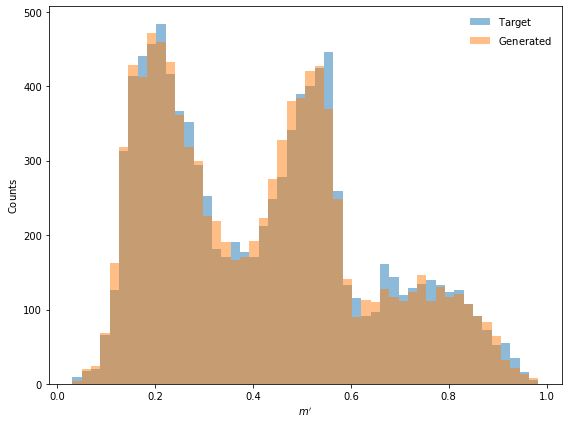

 25%|███████████████▊                                               | 5/20 [17:42<56:14, 224.94s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1067686140537263


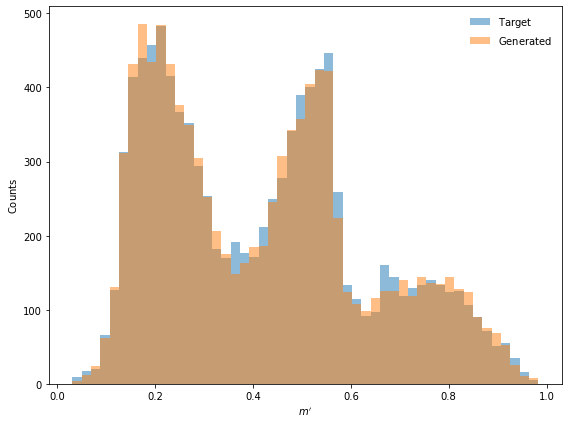

 30%|██████████████████▉                                            | 6/20 [20:04<45:56, 196.93s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1082207334041596


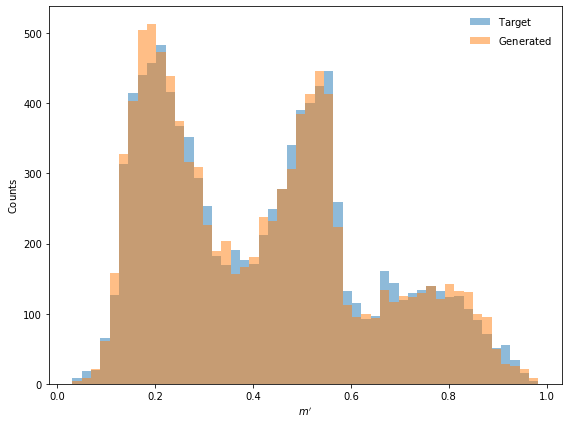

 35%|██████████████████████                                         | 7/20 [22:54<40:45, 188.15s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1102080529928207


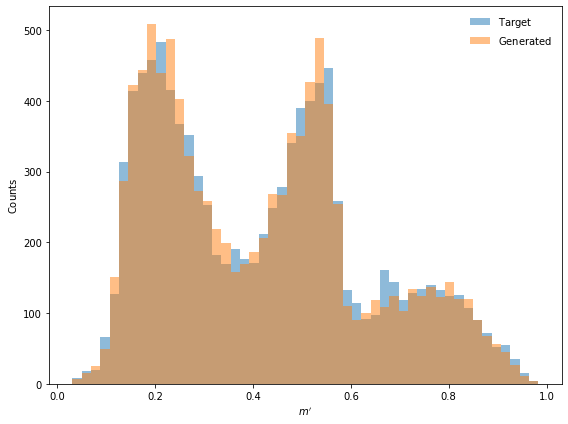

 40%|█████████████████████████▏                                     | 8/20 [27:10<41:55, 209.66s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1099677738547324


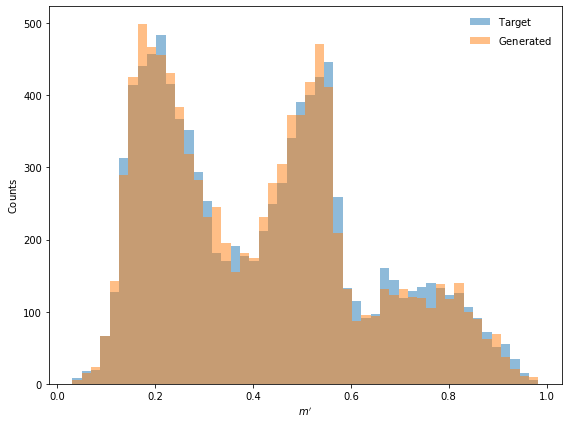

 45%|███████████████████████████▍                                 | 9/20 [53:17<1:56:12, 633.84s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1121819719672204


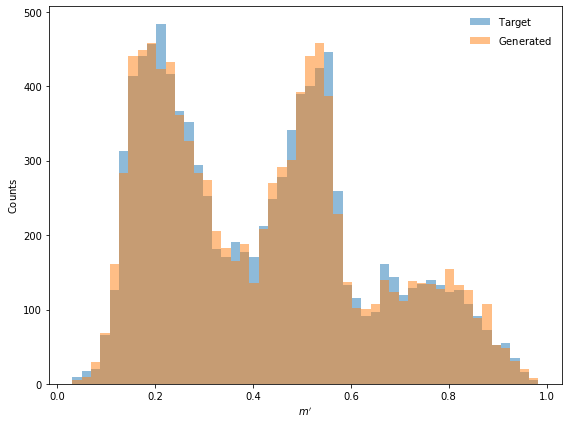

 50%|██████████████████████████████                              | 10/20 [55:43<1:20:34, 483.43s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.111639839708805


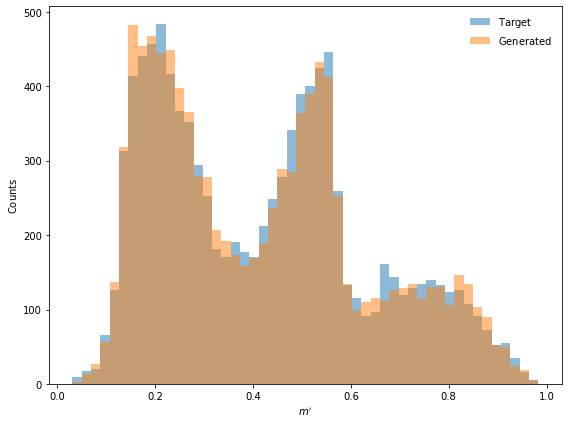

 55%|██████████████████████████████████                            | 11/20 [58:05<56:50, 378.96s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1114416772127151


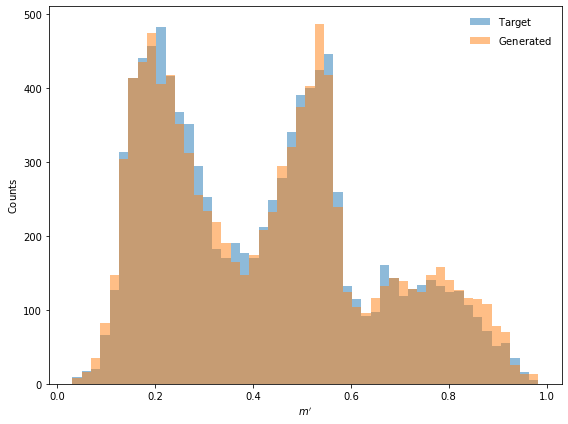

 60%|████████████████████████████████████                        | 12/20 [1:01:06<42:30, 318.81s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1131685855984688


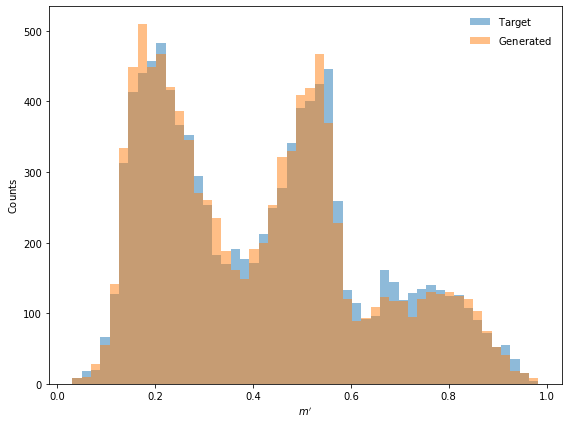

 65%|█████████████████████████████████████▋                    | 13/20 [1:19:26<1:04:47, 555.43s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1132733711600304


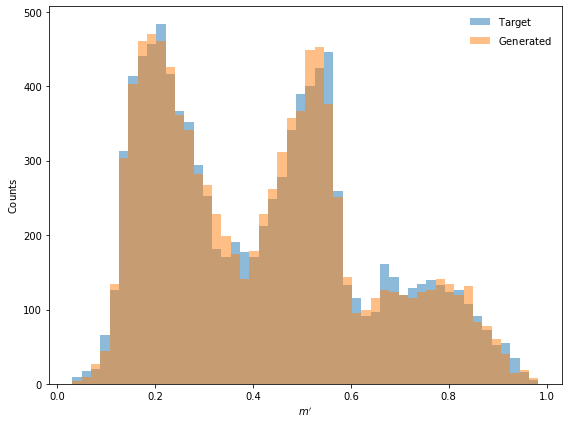

 70%|██████████████████████████████████████████                  | 14/20 [1:22:30<44:19, 443.17s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.114321508705616


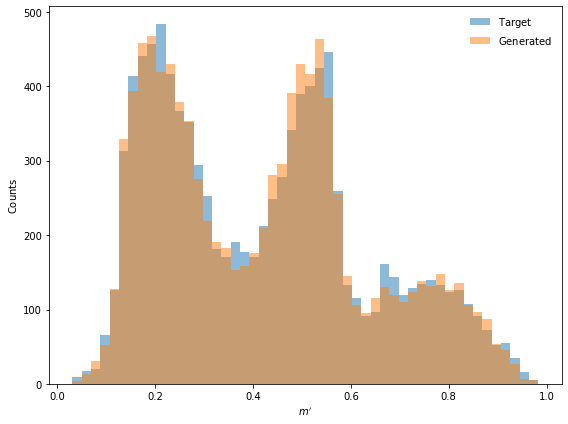

 75%|█████████████████████████████████████████████               | 15/20 [1:25:49<30:47, 369.44s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.114634952545166


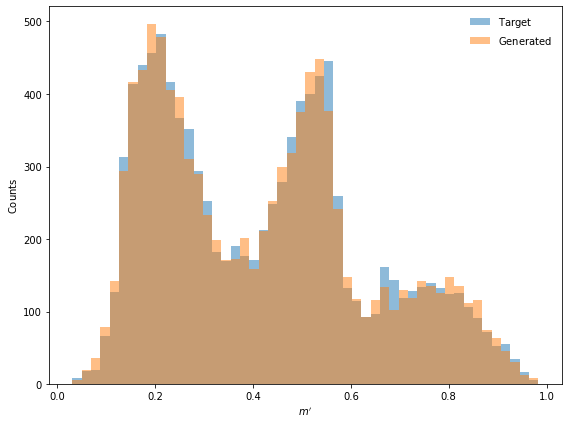

 80%|████████████████████████████████████████████████            | 16/20 [1:29:17<21:23, 320.79s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1156676656007767


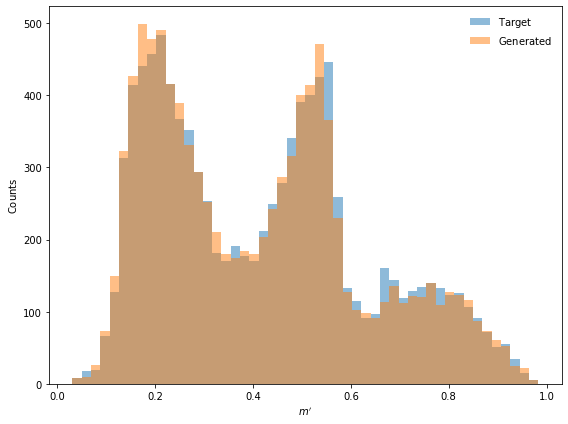

 85%|███████████████████████████████████████████████████         | 17/20 [1:32:34<14:11, 283.78s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1151482298970223


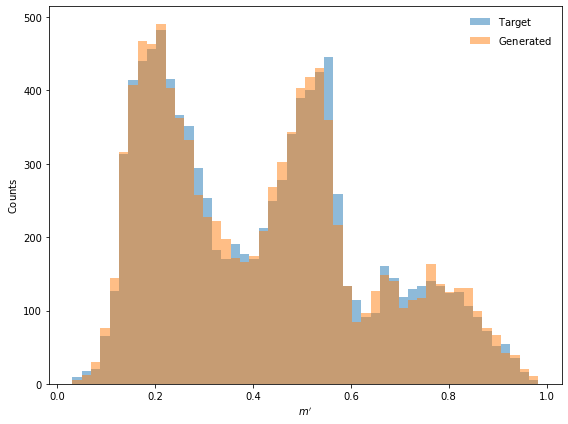

 90%|██████████████████████████████████████████████████████      | 18/20 [1:34:57<08:02, 241.50s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.1153953188657761


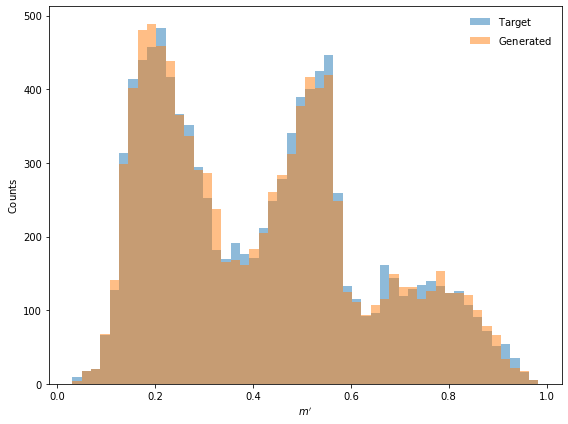

 95%|█████████████████████████████████████████████████████████   | 19/20 [1:39:08<04:04, 244.10s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training Loss: -1.116442566215992


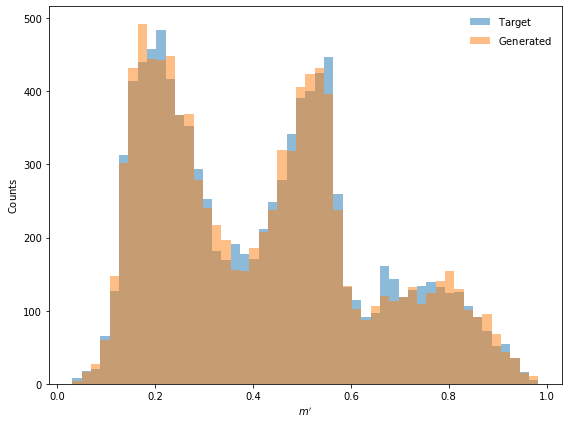

100%|████████████████████████████████████████████████████████████| 20/20 [1:41:29<00:00, 304.49s/it]


In [4]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable cuDNN auto-tuner for optimized performance
torch.backends.cudnn.benchmark = True

# Define the model creation function
def create_model(base='gauss'):
    K = 20  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 100, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)


# Training function with mixed precision and gradient accumulation
def train(dataloader, model, optimizer, scaler, scheduler=None, accumulation_steps=1):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = -model.log_prob(batch).mean()
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    print(f"Training Loss: {total_loss / len(dataloader)}")


# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new model instance
model2 = create_model(base='resampled')

# Count the number of parameters
num_params = count_parameters(model2)
print(f"Number of parameters in the model: {num_params}")

# Adjust batch size
batch_size = 20000 
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 20
learning_rate = 0.0005
min_learning_rate = 1e-6
accumulation_steps = 2  # Gradient accumulation steps

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, min_lr=min_learning_rate)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Training loop with plotting
for epoch in tqdm(range(epochs), ncols=100):
    train(train_dataloader, model2, optimizer, scaler, scheduler, accumulation_steps)
    
    # Generate samples from the trained model
    model2.eval()
    with torch.no_grad():
        samples = model2.sample(10000)
        if isinstance(samples, tuple):
            samples = samples[0]  # Extract the tensor if it's a tuple
        generated_samples = samples.cpu().numpy()

    # Number of samples to visualize
    n_samples = 10000

    # Visualize
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot target distribution
    counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 50, alpha=0.5, label=r'$\mathrm{Target}$')

    # Plot generated samples
    ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

    ax.set_xlabel(r"$m'$")
    ax.set_ylabel(r'$\mathrm{Counts}$')

    ax.legend(loc='best', frameon=False)

    fig.tight_layout()
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.png', dpi=300, pad_inches=.1, bbox_inches='tight')

    plt.show()

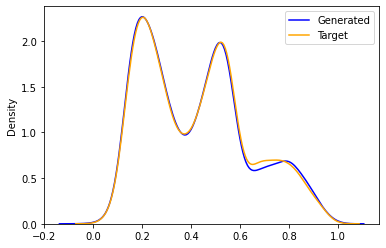

In [32]:
import seaborn as sns
sns.kdeplot(samples[:, 0], label="Generated", color="blue")
sns.kdeplot(mp_thetap[:n_samples, 0], label="Target", color="orange")
plt.legend()


/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Number of parameters in the model: 71577


  0%|                                                                        | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Training Loss = -0.5079, Validation Loss = -0.7647


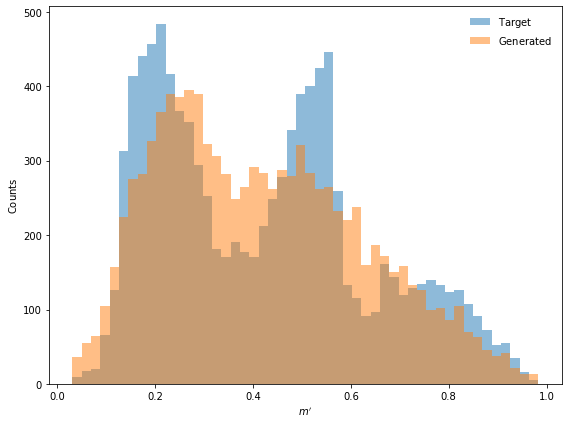

  5%|███                                                          | 1/20 [05:47<1:50:00, 347.39s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 2/20: Training Loss = -0.8667, Validation Loss = -0.9178


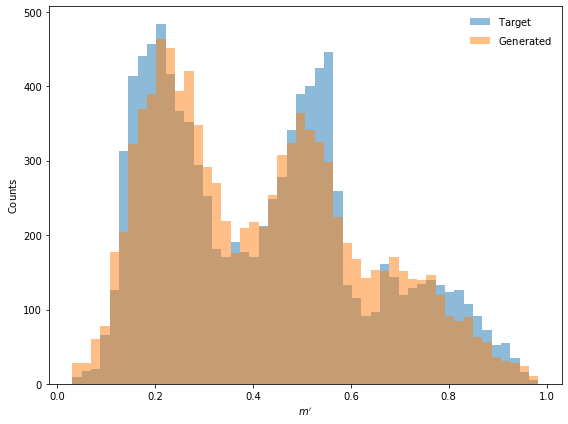

 10%|██████                                                       | 2/20 [11:49<1:46:43, 355.76s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 3/20: Training Loss = -0.9596, Validation Loss = -1.0037


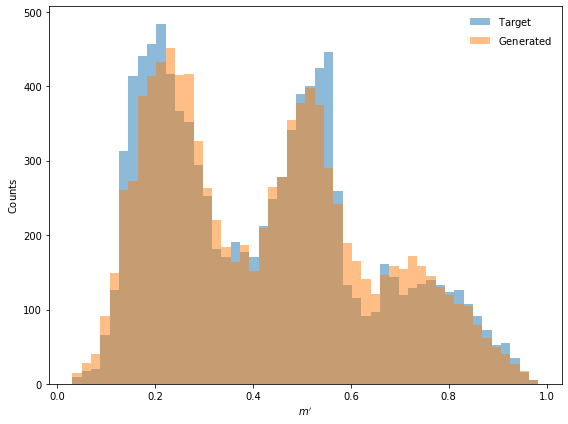

 15%|█████████▏                                                   | 3/20 [17:42<1:40:27, 354.56s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 4/20: Training Loss = -1.0044, Validation Loss = -1.0012


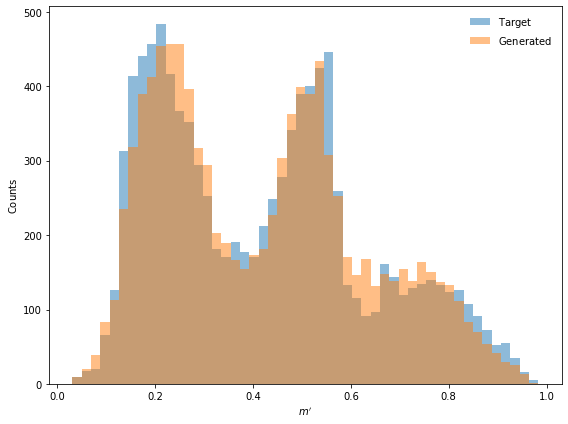

 20%|████████████▏                                                | 4/20 [23:40<1:34:54, 355.90s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 5/20: Training Loss = -1.0271, Validation Loss = -1.0025


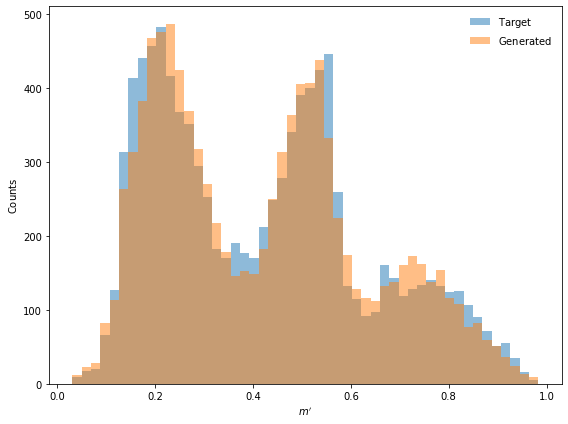

 25%|███████████████▎                                             | 5/20 [29:38<1:29:13, 356.92s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 6/20: Training Loss = -1.0386, Validation Loss = -1.0905


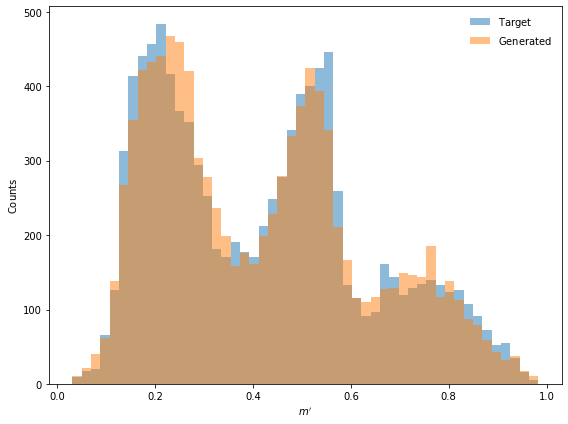

 30%|██████████████████▎                                          | 6/20 [35:51<1:24:31, 362.23s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 7/20: Training Loss = -1.0466, Validation Loss = -1.0034


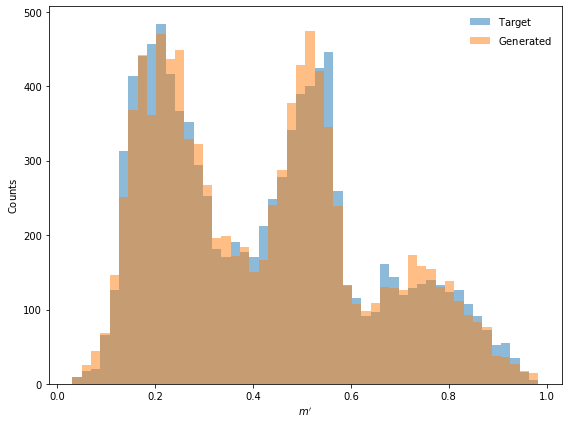

 35%|█████████████████████▎                                       | 7/20 [41:56<1:18:41, 363.23s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 8/20: Training Loss = -1.0509, Validation Loss = -1.0806


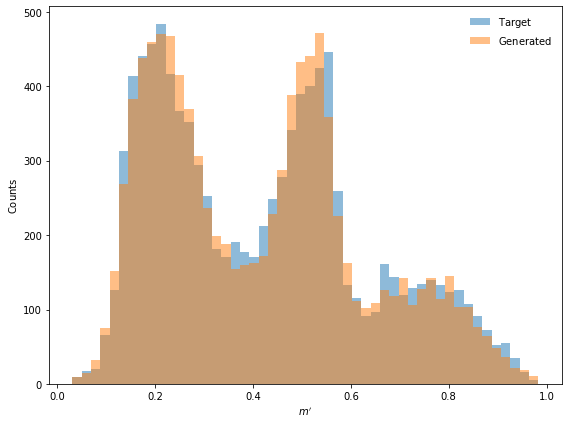

 40%|████████████████████████▍                                    | 8/20 [48:10<1:13:18, 366.52s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 9/20: Training Loss = -1.0561, Validation Loss = -1.0290


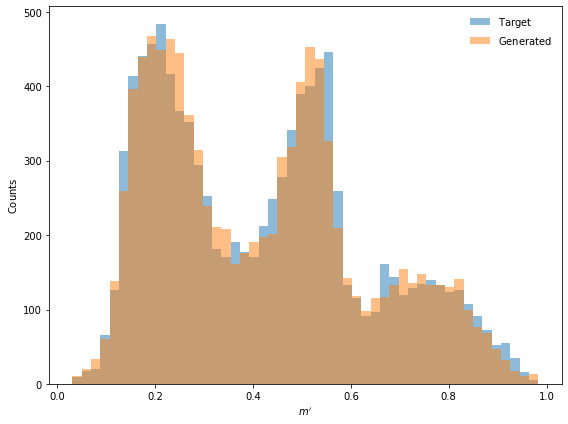

 45%|███████████████████████████▍                                 | 9/20 [54:06<1:06:37, 363.45s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 10/20: Training Loss = -1.0593, Validation Loss = -1.0028


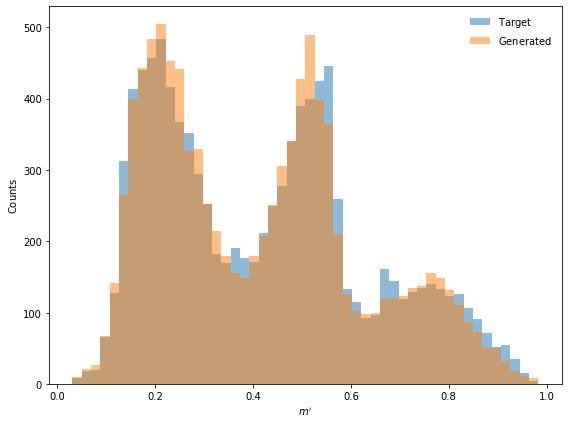

 50%|█████████████████████████████                             | 10/20 [1:00:12<1:00:40, 364.07s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 11/20: Training Loss = -1.0613, Validation Loss = -1.0928


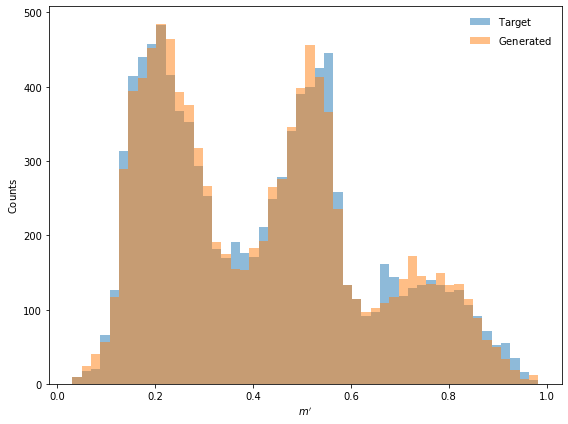

 55%|███████████████████████████████▉                          | 11/20 [1:12:52<1:12:47, 485.29s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 12/20: Training Loss = -1.0644, Validation Loss = -1.0731


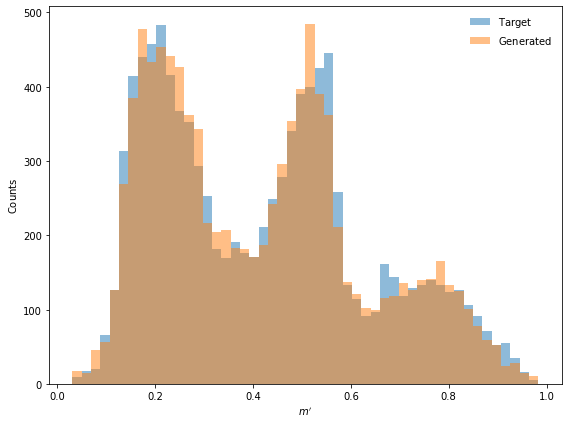

 60%|██████████████████████████████████▊                       | 12/20 [1:19:59<1:02:20, 467.54s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 13/20: Training Loss = -1.0665, Validation Loss = -1.1139


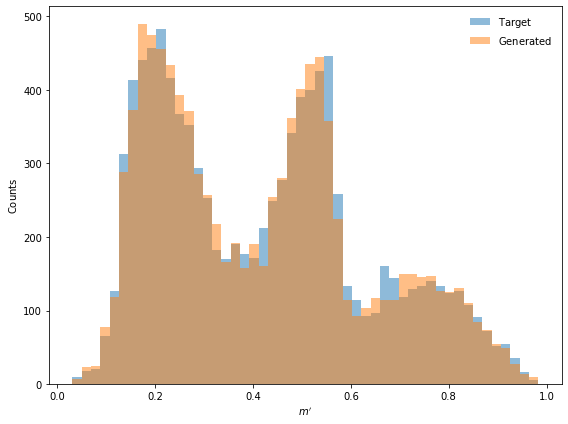

 65%|███████████████████████████████████████                     | 13/20 [1:25:44<50:12, 430.38s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 14/20: Training Loss = -1.0680, Validation Loss = -1.0520


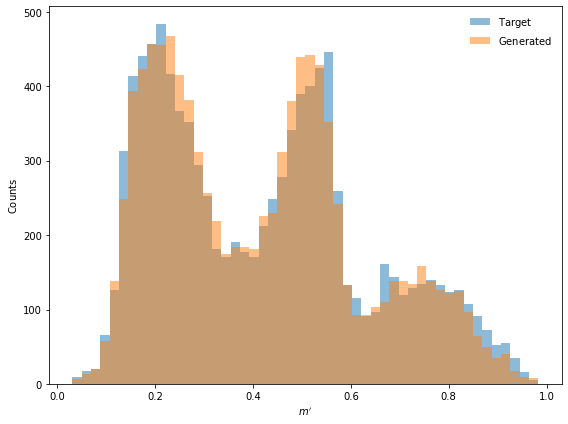

 70%|██████████████████████████████████████████                  | 14/20 [1:31:25<40:20, 403.49s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 15/20: Training Loss = -1.0688, Validation Loss = -1.0707


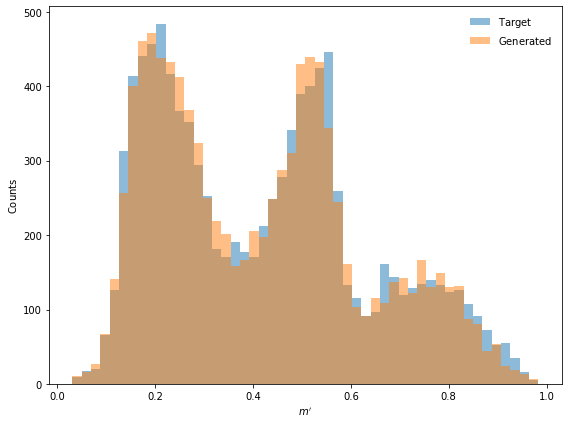

 75%|█████████████████████████████████████████████               | 15/20 [1:37:13<32:13, 386.70s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 16/20: Training Loss = -1.0717, Validation Loss = -1.0336


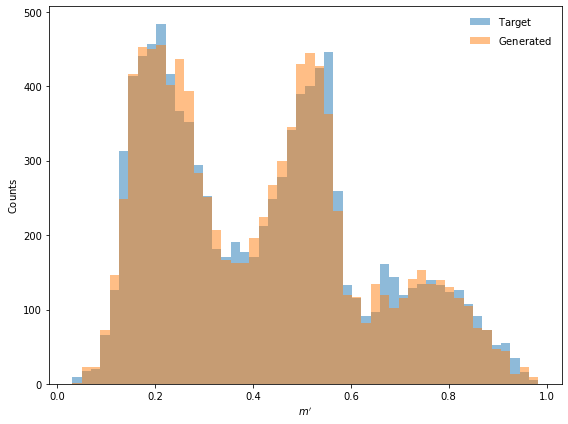

 80%|████████████████████████████████████████████████            | 16/20 [1:43:02<25:01, 375.41s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 17/20: Training Loss = -1.0715, Validation Loss = -1.0571


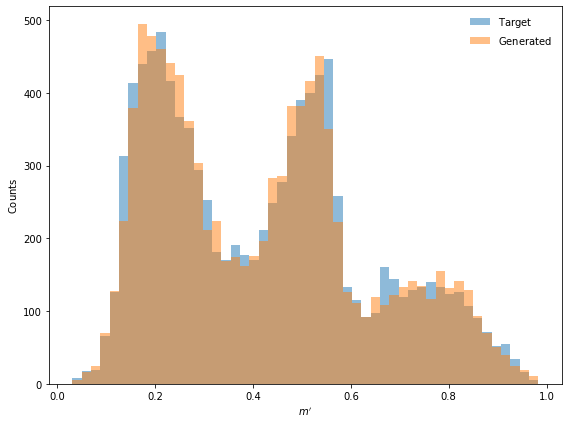

 85%|███████████████████████████████████████████████████         | 17/20 [1:48:51<18:22, 367.42s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 18/20: Training Loss = -1.0730, Validation Loss = -1.0923


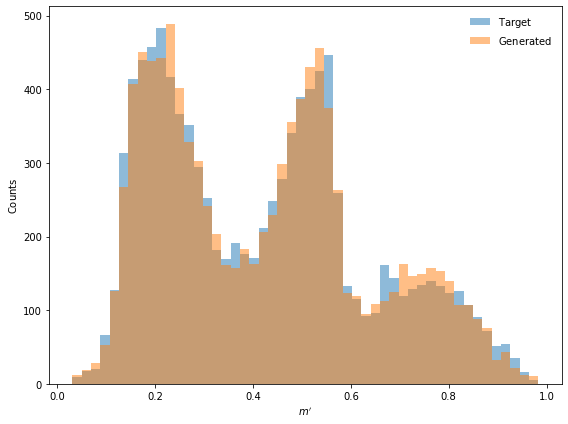

 90%|██████████████████████████████████████████████████████      | 18/20 [1:54:29<11:56, 358.46s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 19/20: Training Loss = -1.0752, Validation Loss = -1.0637


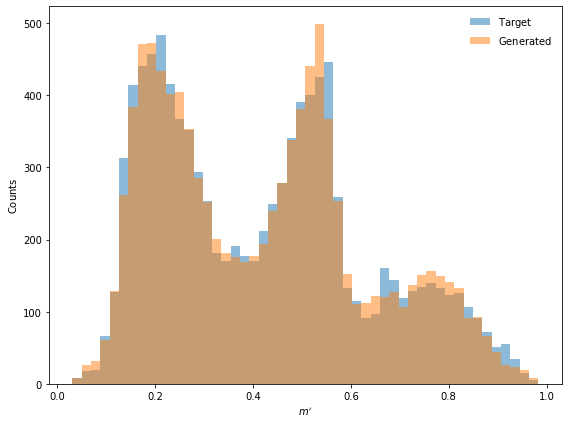

 95%|█████████████████████████████████████████████████████████   | 19/20 [2:00:14<05:54, 354.61s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 20/20: Training Loss = -1.0760, Validation Loss = -1.0622


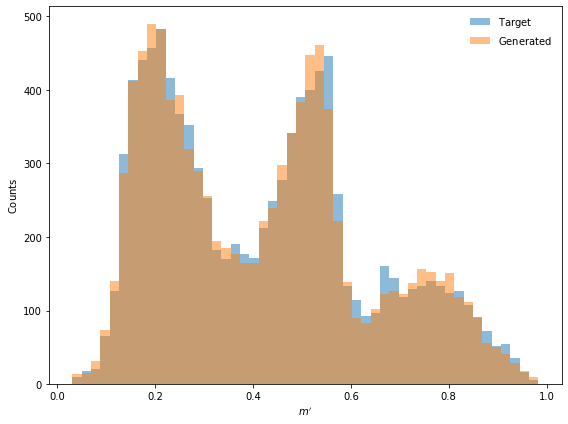

100%|████████████████████████████████████████████████████████████| 20/20 [2:06:21<00:00, 379.07s/it]


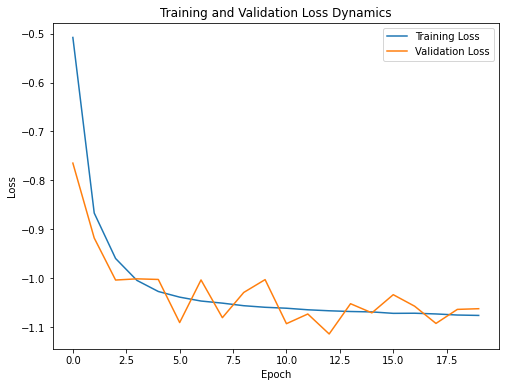

In [9]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable cuDNN auto-tuner for optimized performance
torch.backends.cudnn.benchmark = True

# Define the model creation function
def create_model(base='gauss'):
    K = 4  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 100, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)

# Training function with mixed precision and gradient accumulation
def train(dataloader, model, optimizer, scaler, scheduler=None, accumulation_steps=1):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = -model.log_prob(batch).mean()
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    return total_loss / len(dataloader)  # Return average loss

# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new model instance
model2 = create_model(base='resampled')

# Count the number of parameters
num_params = count_parameters(model2)
print(f"Number of parameters in the model: {num_params}")

# Adjust batch size
batch_size = 256
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 20
learning_rate = 0.000005
min_learning_rate = 1e-6
accumulation_steps = 5  # Gradient accumulation steps

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience= 1, min_lr=min_learning_rate)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Loss tracking lists for visualization
train_losses = []
val_losses = []

# Training loop with plotting
for epoch in tqdm(range(epochs), ncols=100):
    # Train the model and track loss
    train_loss = train(train_dataloader, model2, optimizer, scaler, scheduler, accumulation_steps)
    train_losses.append(train_loss)
    
    # Evaluate on validation set after each epoch
    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = val_batch.to(device)
            loss = -model2.log_prob(val_batch).mean()
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))
    
    print(f"Epoch {epoch+1}/{epochs}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss / len(val_dataloader):.4f}")
    
    # Generate samples from the trained model
    with torch.no_grad():
        samples = model2.sample(10000)
        if isinstance(samples, tuple):
            samples = samples[0]  # Extract the tensor if it's a tuple
        generated_samples = samples.cpu().numpy()

    # Visualize results
    n_samples = 10000
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot target distribution
    counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 50, alpha=0.5, label=r'$\mathrm{Target}$')

    # Plot generated samples
    ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

    ax.set_xlabel(r"$m'$")
    ax.set_ylabel(r'$\mathrm{Counts}$')
    ax.legend(loc='best', frameon=False)

    fig.tight_layout()
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.png', dpi=300, pad_inches=.1, bbox_inches='tight')

    plt.show()

# Plot the loss dynamics
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title("Training and Validation Loss Dynamics")
plt.show()


/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Number of parameters in the model: 76337


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Epoch 1/40: Training Loss = -0.2761, Validation Loss = -0.3844


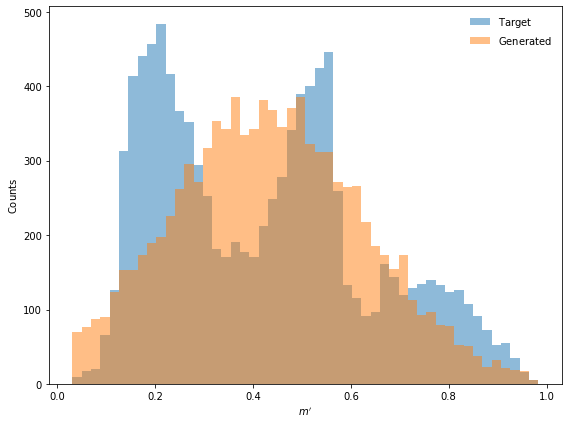

  2%|█▌                                                           | 1/40 [02:20<1:31:34, 140.87s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 2/40: Training Loss = -0.5016, Validation Loss = -0.6260


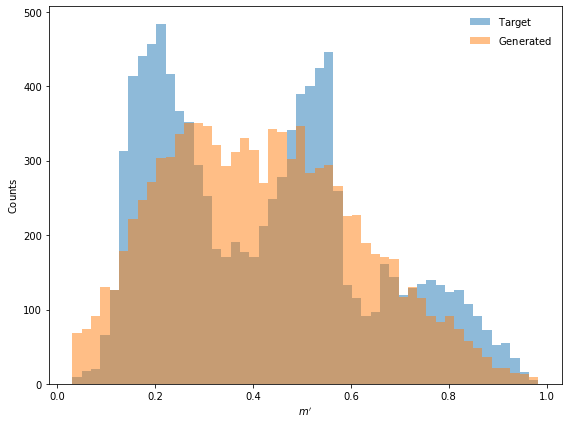

  5%|███                                                          | 2/40 [04:45<1:30:44, 143.29s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 3/40: Training Loss = -0.7446, Validation Loss = -0.8338


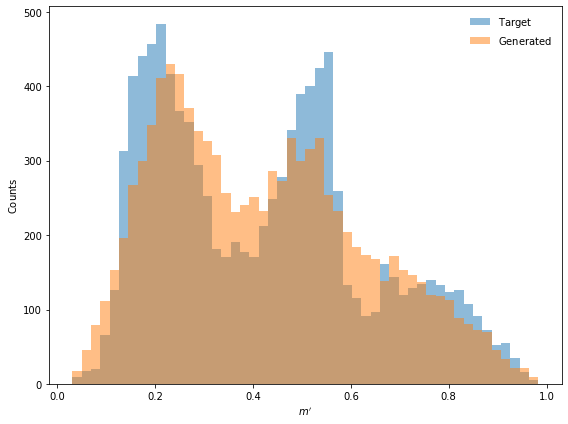

  8%|████▌                                                        | 3/40 [07:11<1:29:00, 144.33s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 4/40: Training Loss = -0.9001, Validation Loss = -0.9386


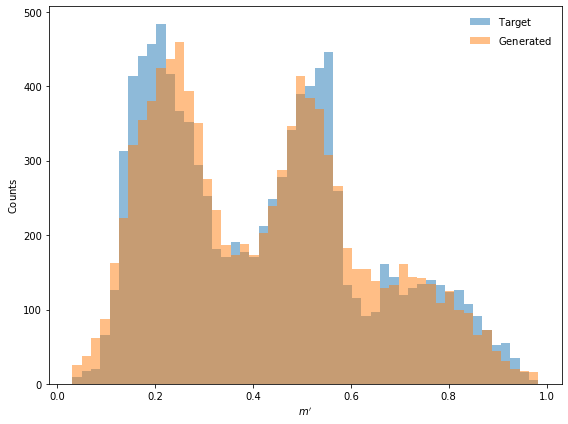

 10%|██████                                                       | 4/40 [09:46<1:29:15, 148.75s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 5/40: Training Loss = -0.9816, Validation Loss = -1.0055


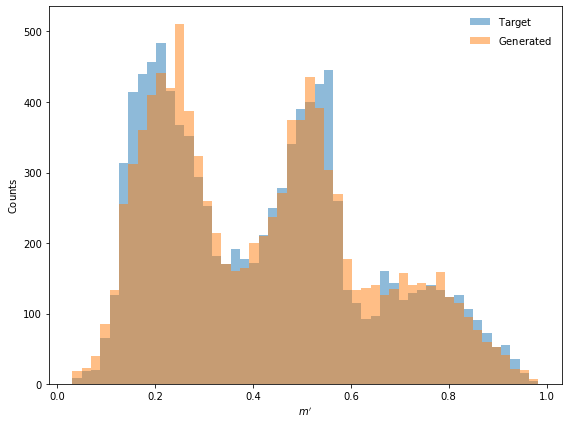

 12%|███████▋                                                     | 5/40 [12:16<1:27:02, 149.22s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 6/40: Training Loss = -1.0219, Validation Loss = -1.0278


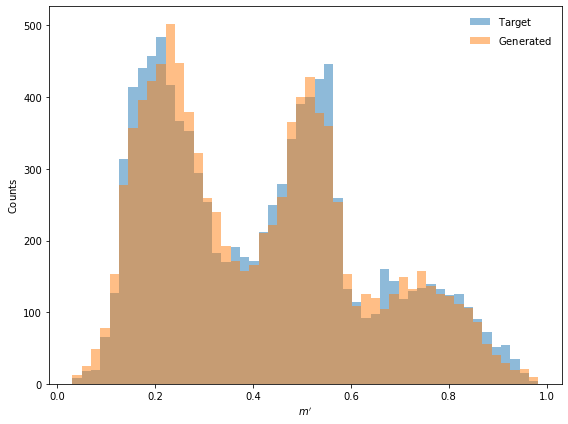

 15%|█████████▏                                                   | 6/40 [14:44<1:24:18, 148.78s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 7/40: Training Loss = -1.0437, Validation Loss = -1.0381


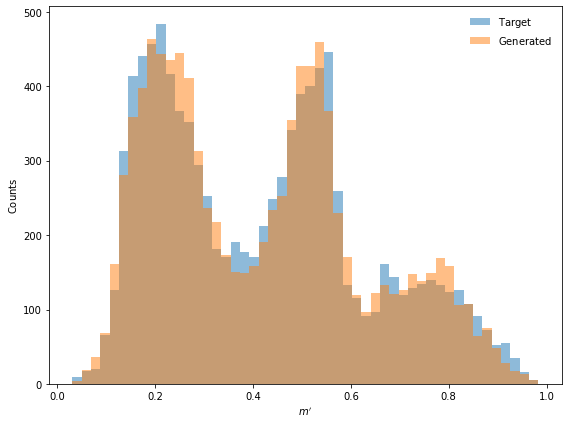

 18%|██████████▋                                                  | 7/40 [17:15<1:22:12, 149.46s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 8/40: Training Loss = -1.0530, Validation Loss = -1.0628


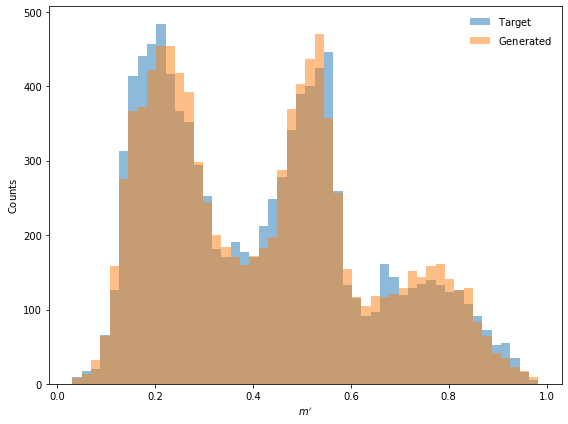

 20%|████████████▏                                                | 8/40 [19:42<1:19:16, 148.64s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 9/40: Training Loss = -1.0614, Validation Loss = -1.0710


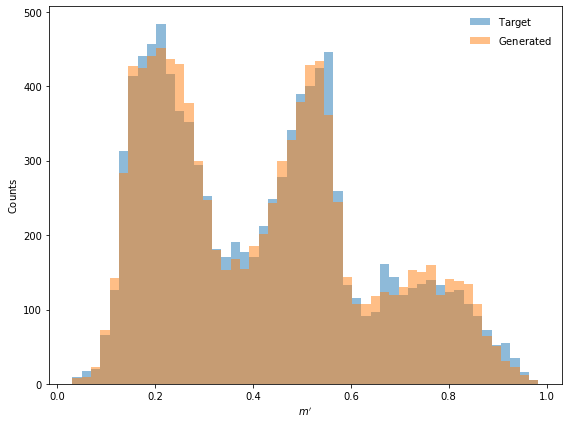

 22%|█████████████▋                                               | 9/40 [22:13<1:17:07, 149.28s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 10/40: Training Loss = -1.0644, Validation Loss = -1.0584


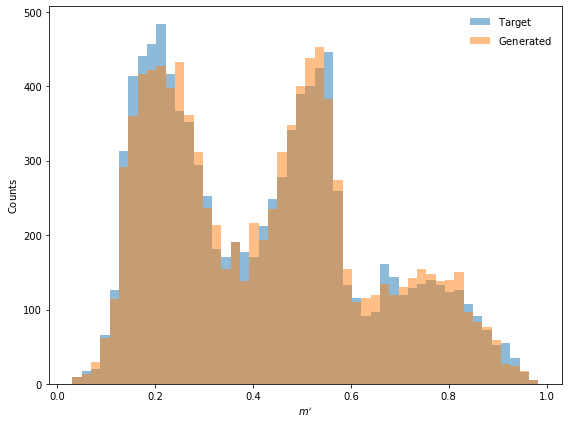

 25%|███████████████                                             | 10/40 [24:35<1:13:31, 147.04s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 11/40: Training Loss = -1.0686, Validation Loss = -1.0541


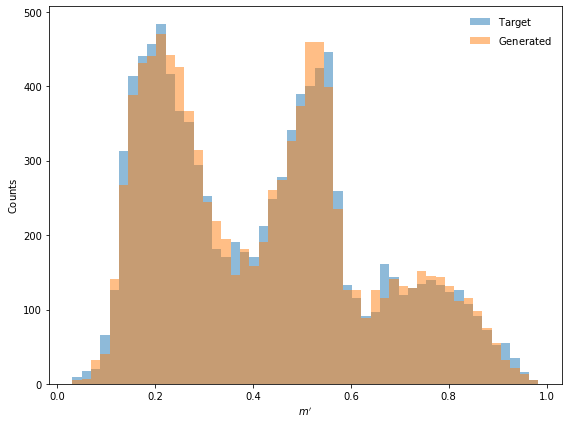

 28%|████████████████▌                                           | 11/40 [26:44<1:08:22, 141.45s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 12/40: Training Loss = -1.0734, Validation Loss = -1.0959


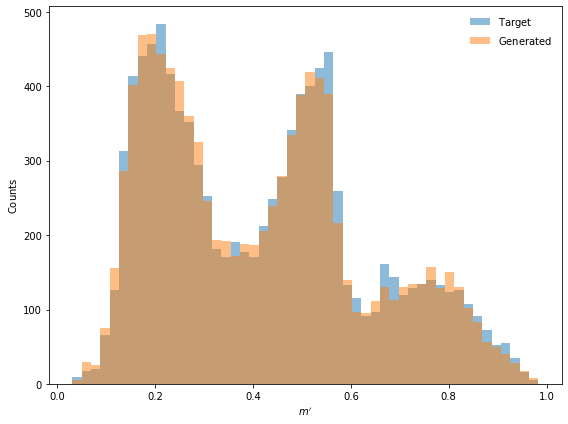

 30%|██████████████████                                          | 12/40 [28:53<1:04:16, 137.73s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 13/40: Training Loss = -1.0732, Validation Loss = -1.0669


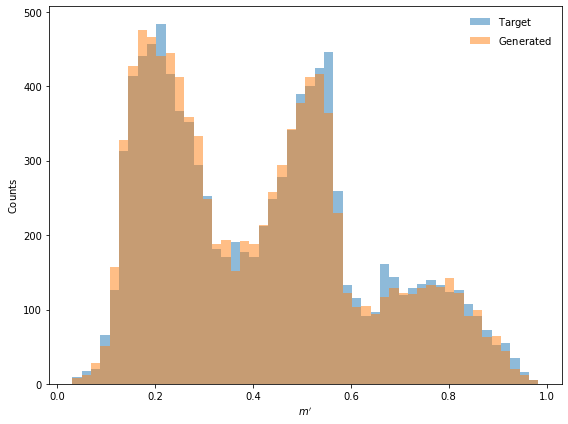

 32%|███████████████████▌                                        | 13/40 [31:00<1:00:28, 134.40s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 14/40: Training Loss = -1.0772, Validation Loss = -1.0786


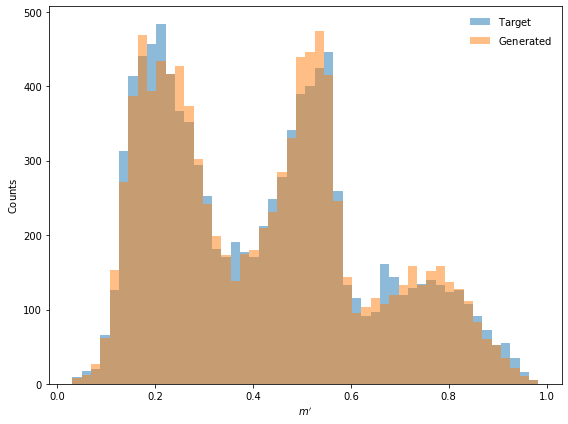

 35%|█████████████████████▋                                        | 14/40 [33:09<57:36, 132.96s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 15/40: Training Loss = -1.0788, Validation Loss = -1.1057


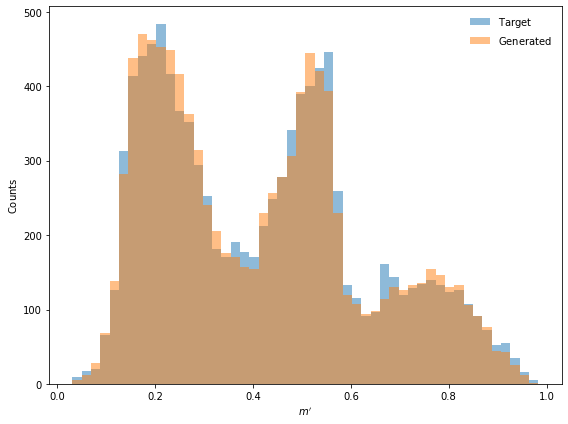

 38%|███████████████████████▎                                      | 15/40 [35:19<54:58, 131.92s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 16/40: Training Loss = -1.0802, Validation Loss = -1.0790


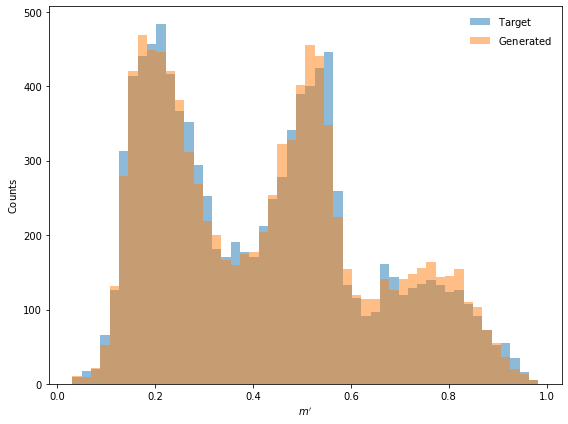

 40%|████████████████████████▊                                     | 16/40 [37:30<52:42, 131.76s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 17/40: Training Loss = -1.0800, Validation Loss = -1.0803


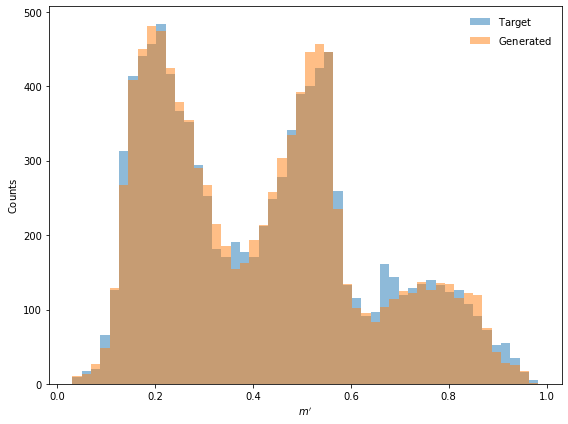

 42%|██████████████████████████▎                                   | 17/40 [39:42<50:31, 131.82s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 18/40: Training Loss = -1.0806, Validation Loss = -1.0852


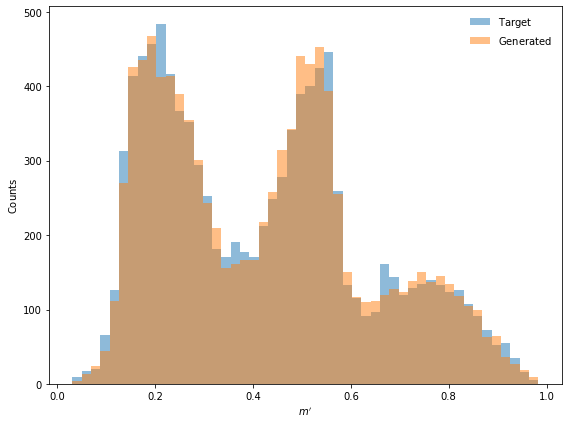

 45%|███████████████████████████▉                                  | 18/40 [41:52<48:07, 131.23s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 19/40: Training Loss = -1.0832, Validation Loss = -1.0686


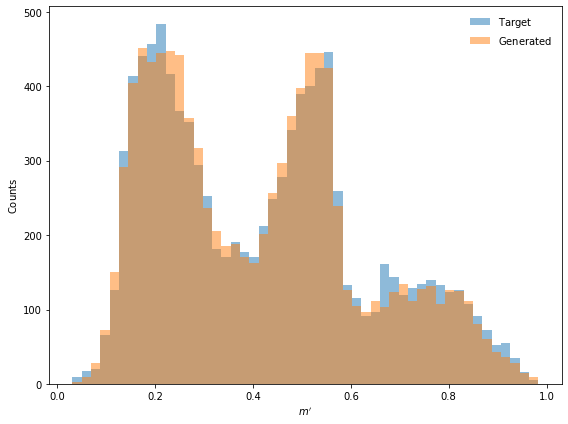

 48%|█████████████████████████████▍                                | 19/40 [44:00<45:36, 130.31s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 20/40: Training Loss = -1.0828, Validation Loss = -1.0770


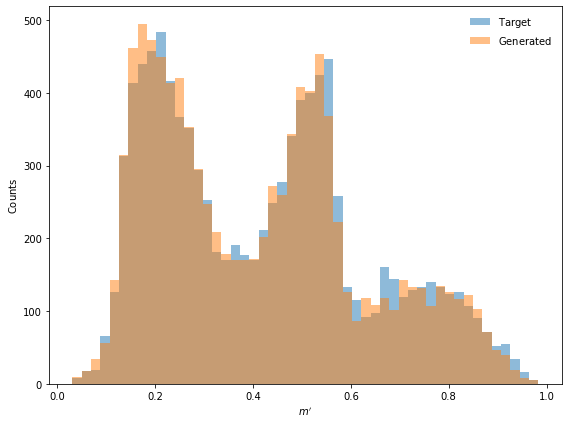

 50%|███████████████████████████████                               | 20/40 [46:07<43:03, 129.19s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 21/40: Training Loss = -1.0852, Validation Loss = -1.0956


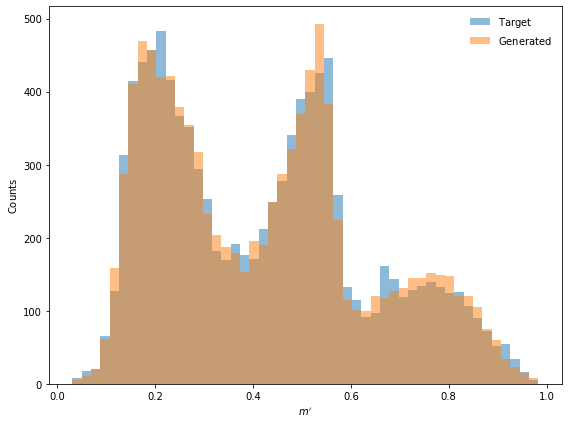

 52%|████████████████████████████████▌                             | 21/40 [48:12<40:31, 128.00s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 22/40: Training Loss = -1.0858, Validation Loss = -1.0627


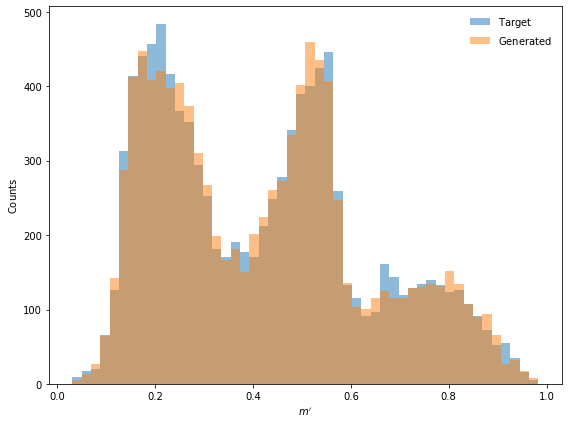

 55%|██████████████████████████████████                            | 22/40 [50:25<38:52, 129.56s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 23/40: Training Loss = -1.0868, Validation Loss = -1.0965


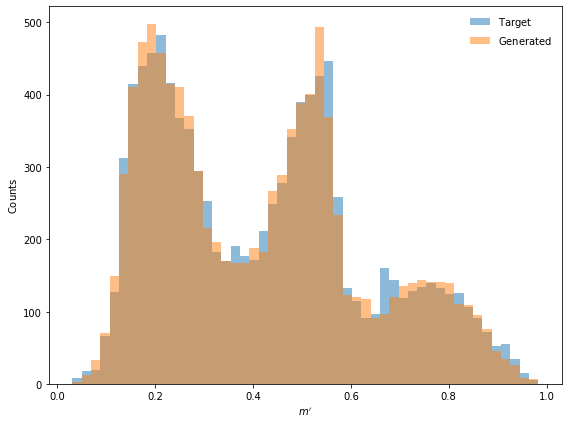

 57%|███████████████████████████████████▋                          | 23/40 [52:37<36:53, 130.23s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 24/40: Training Loss = -1.0855, Validation Loss = -1.0840


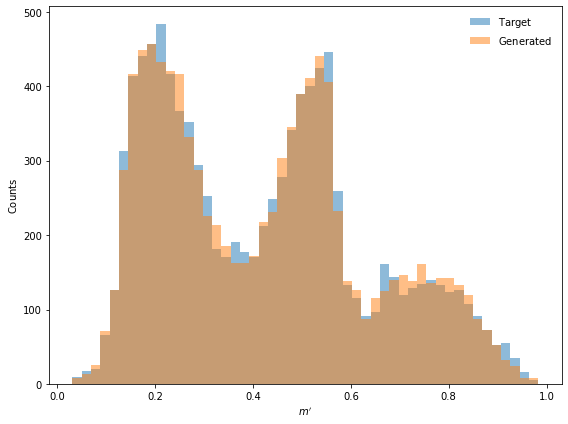

 60%|█████████████████████████████████████▏                        | 24/40 [54:45<34:35, 129.71s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 25/40: Training Loss = -1.0879, Validation Loss = -1.0923


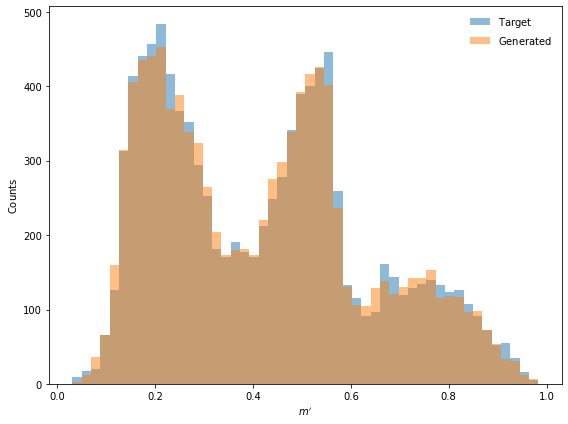

 62%|██████████████████████████████████████▊                       | 25/40 [56:59<32:42, 130.84s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 26/40: Training Loss = -1.0883, Validation Loss = -1.0723


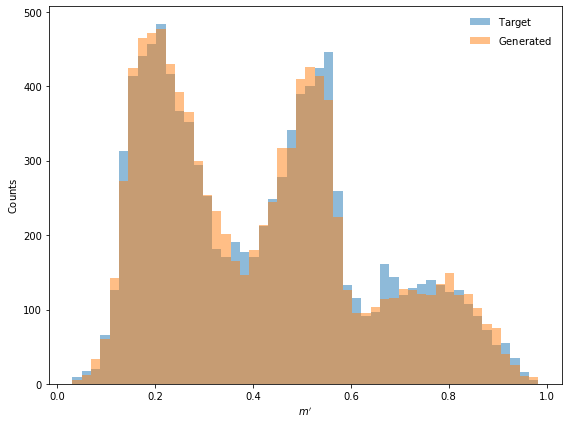

 65%|████████████████████████████████████████▎                     | 26/40 [59:14<30:49, 132.13s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 27/40: Training Loss = -1.0891, Validation Loss = -1.1014


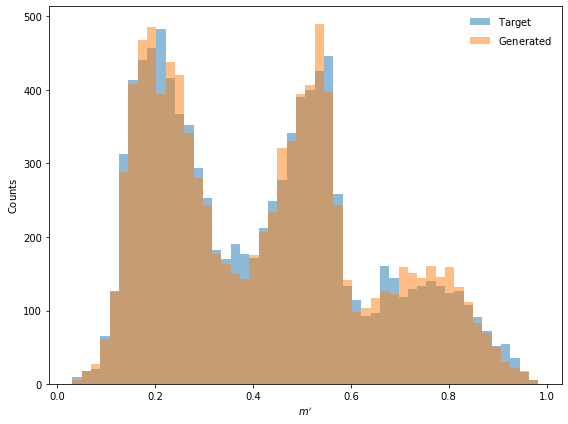

 68%|████████████████████████████████████████▌                   | 27/40 [1:01:31<28:57, 133.65s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 28/40: Training Loss = -1.0917, Validation Loss = -1.0871


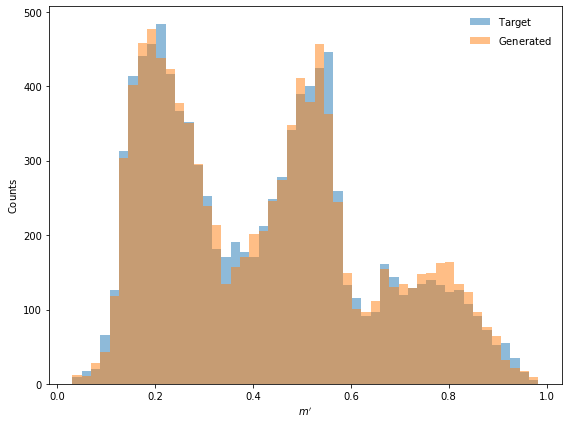

 70%|██████████████████████████████████████████                  | 28/40 [1:03:38<26:19, 131.62s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 29/40: Training Loss = -1.0908, Validation Loss = -1.0838


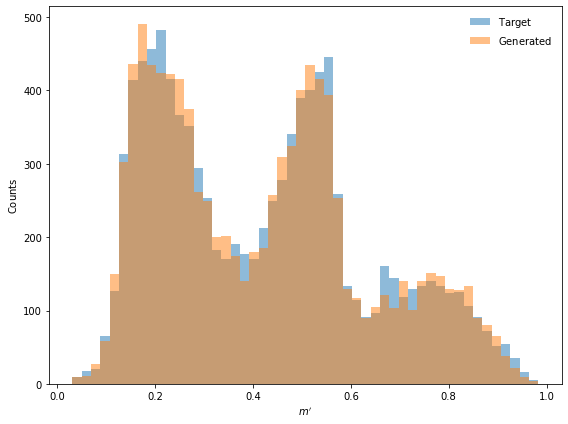

 72%|███████████████████████████████████████████▌                | 29/40 [1:05:48<24:02, 131.17s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 30/40: Training Loss = -1.0903, Validation Loss = -1.0700


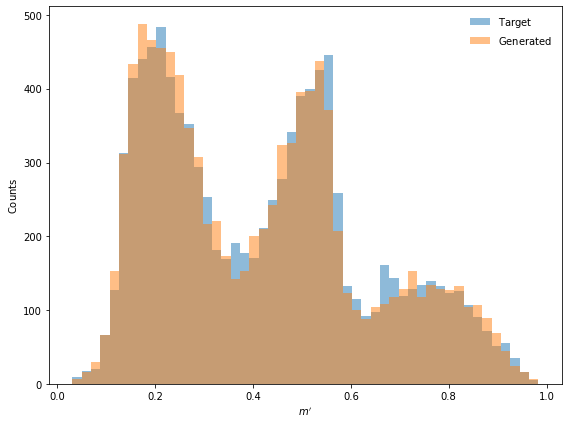

 75%|█████████████████████████████████████████████               | 30/40 [1:07:56<21:42, 130.22s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 31/40: Training Loss = -1.0912, Validation Loss = -1.0949


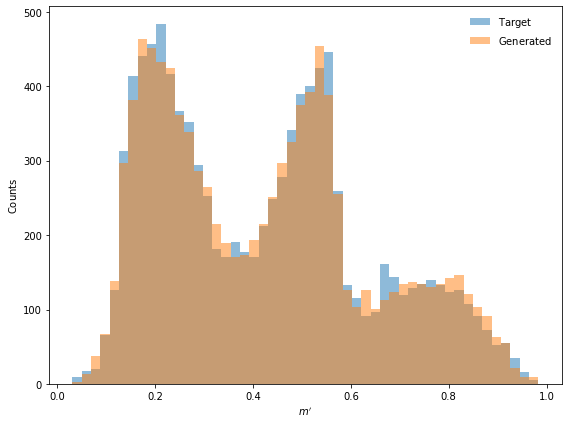

 78%|██████████████████████████████████████████████▌             | 31/40 [1:10:10<19:40, 131.20s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 32/40: Training Loss = -1.0942, Validation Loss = -1.0947


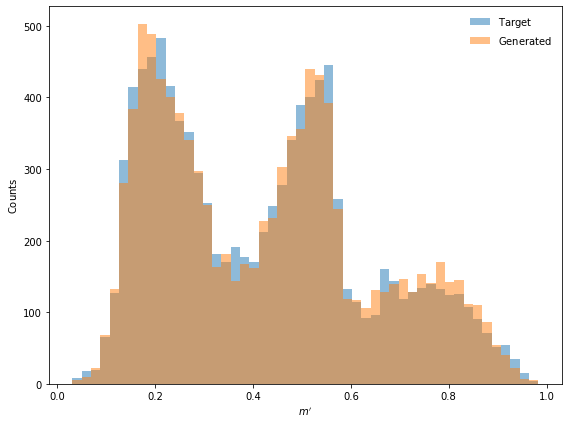

 80%|████████████████████████████████████████████████            | 32/40 [1:12:23<17:33, 131.71s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 33/40: Training Loss = -1.0920, Validation Loss = -1.1196


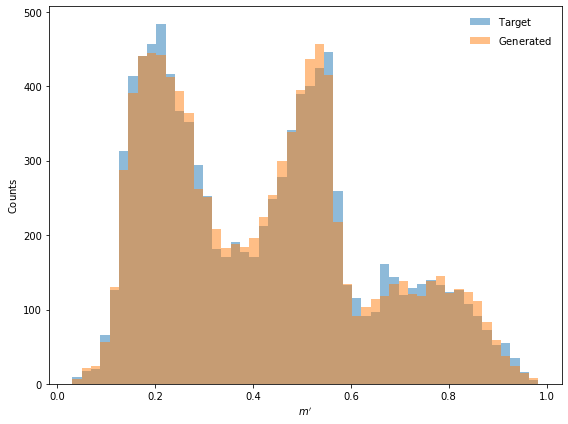

 82%|█████████████████████████████████████████████████▌          | 33/40 [1:14:38<15:29, 132.74s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 34/40: Training Loss = -1.0930, Validation Loss = -1.1032


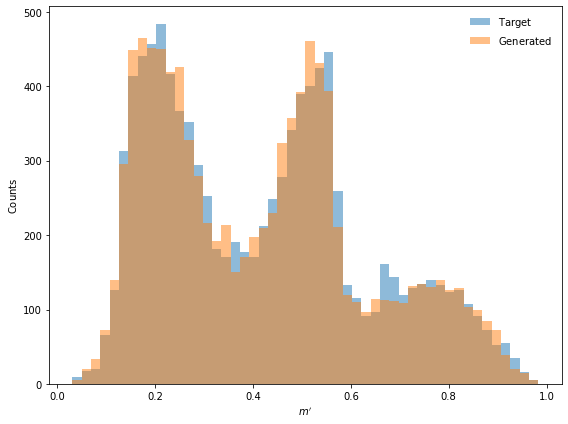

 85%|███████████████████████████████████████████████████         | 34/40 [1:16:51<13:16, 132.75s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 35/40: Training Loss = -1.0937, Validation Loss = -1.0879


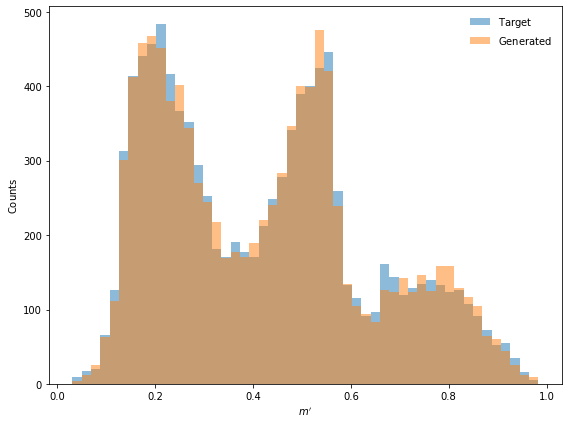

 88%|████████████████████████████████████████████████████▌       | 35/40 [1:19:02<11:02, 132.42s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 36/40: Training Loss = -1.0950, Validation Loss = -1.0945


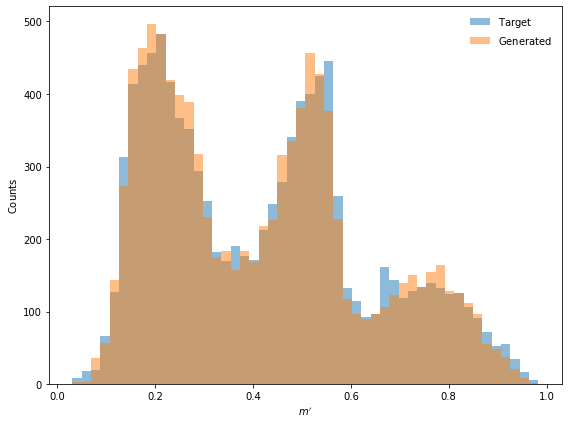

 90%|██████████████████████████████████████████████████████      | 36/40 [1:21:16<08:51, 132.93s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 37/40: Training Loss = -1.0937, Validation Loss = -1.0859


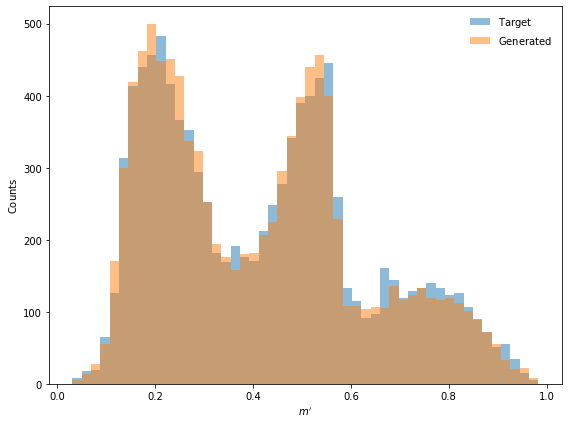

 92%|███████████████████████████████████████████████████████▌    | 37/40 [1:23:25<06:35, 131.75s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 38/40: Training Loss = -1.0945, Validation Loss = -1.1052


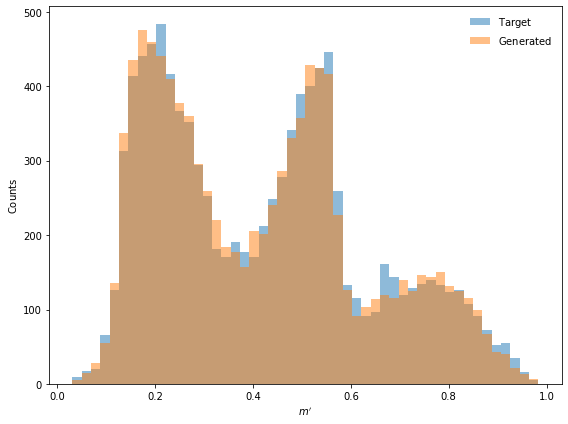

 95%|█████████████████████████████████████████████████████████   | 38/40 [1:25:36<04:22, 131.33s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 39/40: Training Loss = -1.0952, Validation Loss = -1.1060


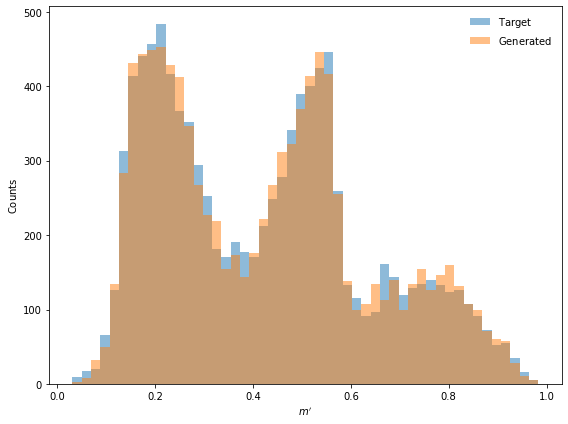

 98%|██████████████████████████████████████████████████████████▌ | 39/40 [1:27:57<02:14, 134.45s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 40/40: Training Loss = -1.0953, Validation Loss = -1.0911


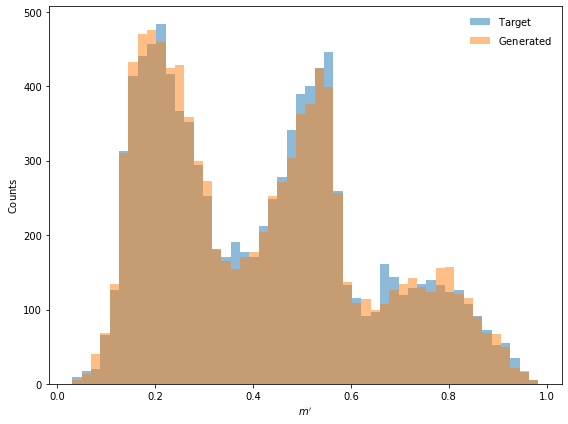

100%|████████████████████████████████████████████████████████████| 40/40 [1:30:04<00:00, 135.11s/it]


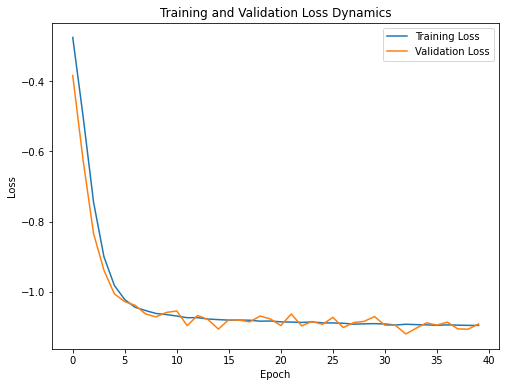

In [ ]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable cuDNN auto-tuner for optimized performance
torch.backends.cudnn.benchmark = True

# Define the model creation function
def create_model(base='gauss'):
    K = 8  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 300, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)

# Training function with mixed precision and gradient accumulation
def train(dataloader, model, optimizer, scaler, scheduler=None, accumulation_steps=1):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = -model.log_prob(batch).mean()
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    return total_loss / len(dataloader)  # Return average loss

# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new model instance
model2 = create_model(base='resampled')

# Count the number of parameters
num_params = count_parameters(model2)
print(f"Number of parameters in the model: {num_params}")

# Adjust batch size
batch_size = 20000
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 40
learning_rate = 0.0001
min_learning_rate = 1e-6
accumulation_steps = 5  # Gradient accumulation steps

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience= 1, min_lr=min_learning_rate)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Loss tracking lists for visualization
train_losses = []
val_losses = []

# Training loop with plotting
for epoch in tqdm(range(epochs), ncols=100):
    # Train the model and track loss
    train_loss = train(train_dataloader, model2, optimizer, scaler, scheduler, accumulation_steps)
    train_losses.append(train_loss)
    
    # Evaluate on validation set after each epoch
    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = val_batch.to(device)
            loss = -model2.log_prob(val_batch).mean()
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))
    
    print(f"Epoch {epoch+1}/{epochs}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss / len(val_dataloader):.4f}")
    
    # Generate samples from the trained model
    with torch.no_grad():
        samples = model2.sample(10000)
        if isinstance(samples, tuple):
            samples = samples[0]  # Extract the tensor if it's a tuple
        generated_samples = samples.cpu().numpy()

    # Visualize results
    n_samples = 10000
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot target distribution
    counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 50, alpha=0.5, label=r'$\mathrm{Target}$')

    # Plot generated samples
    ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

    ax.set_xlabel(r"$m'$")
    ax.set_ylabel(r'$\mathrm{Counts}$')
    ax.legend(loc='best', frameon=False)

    fig.tight_layout()
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.png', dpi=300, pad_inches=.1, bbox_inches='tight')

    plt.show()

# Plot the loss dynamics
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title("Training and Validation Loss Dynamics")
plt.show()


/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Number of parameters in the model: 278985


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Epoch 1/40: Training Loss = -0.4015, Validation Loss = -0.6186


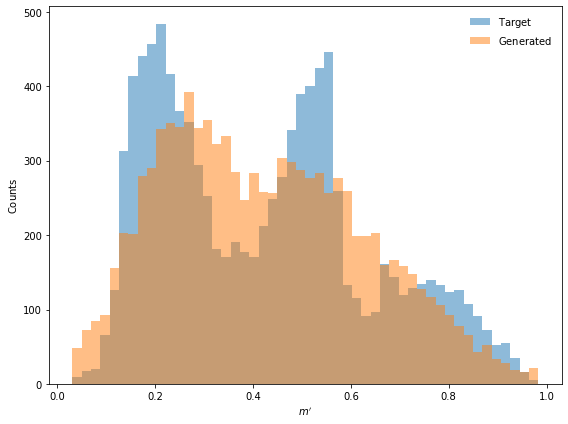

  2%|█▌                                                           | 1/40 [04:19<2:48:21, 259.00s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 2/40: Training Loss = -0.7885, Validation Loss = -0.8977


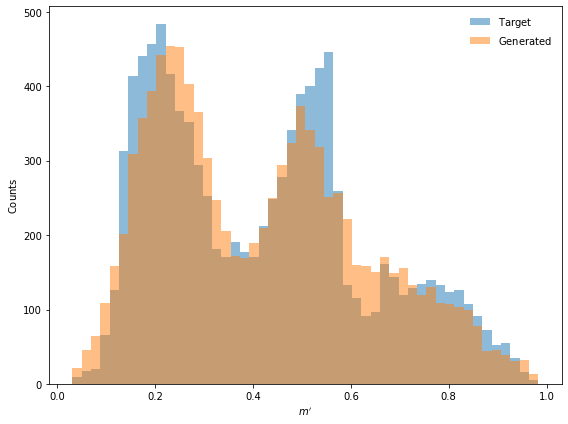

  5%|███                                                          | 2/40 [08:37<2:43:50, 258.71s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 3/40: Training Loss = -0.9653, Validation Loss = -0.9811


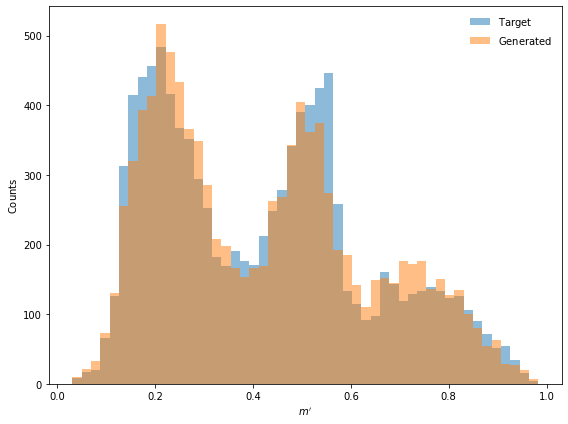

  8%|████▌                                                        | 3/40 [12:55<2:39:27, 258.58s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 4/40: Training Loss = -1.0279, Validation Loss = -1.0420


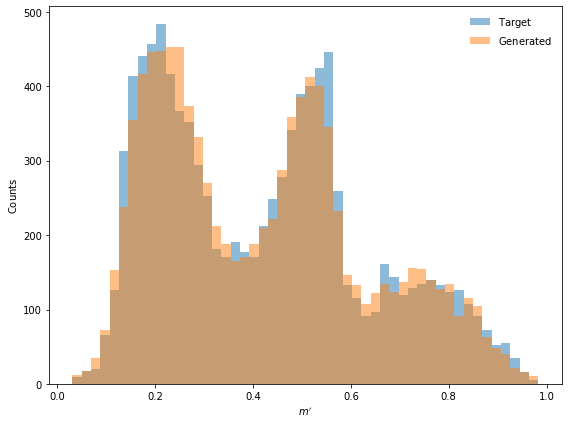

 10%|██████                                                       | 4/40 [17:27<2:38:14, 263.74s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 5/40: Training Loss = -1.0500, Validation Loss = -1.0722


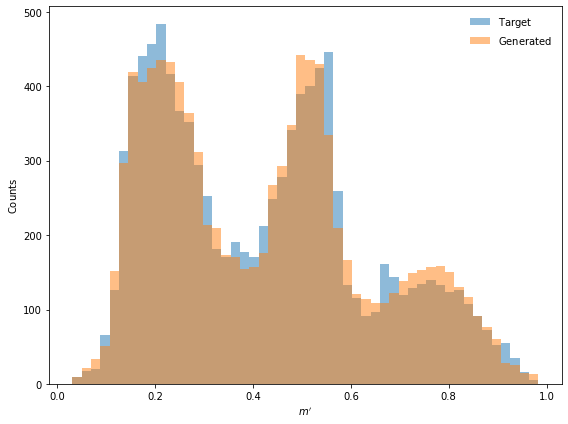

 12%|███████▋                                                     | 5/40 [21:50<2:33:45, 263.59s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 6/40: Training Loss = -1.0596, Validation Loss = -1.0843


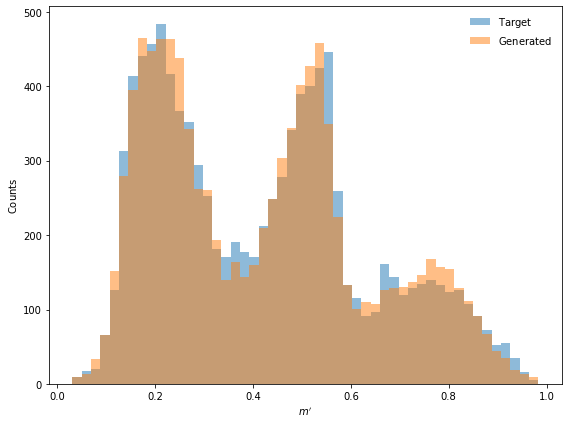

 15%|█████████▏                                                   | 6/40 [26:14<2:29:21, 263.59s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 7/40: Training Loss = -1.0682, Validation Loss = -1.0785


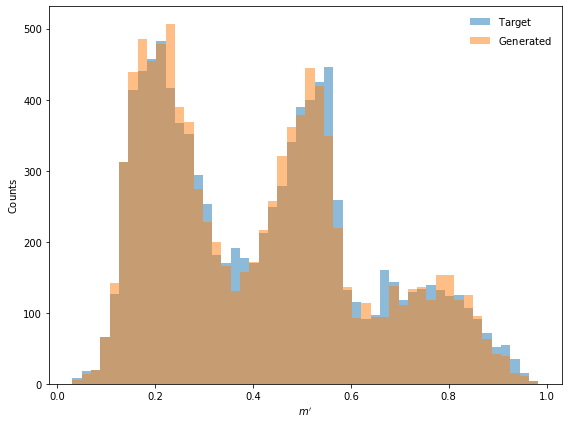

 18%|██████████▋                                                  | 7/40 [30:35<2:24:30, 262.74s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 8/40: Training Loss = -1.0730, Validation Loss = -1.0640


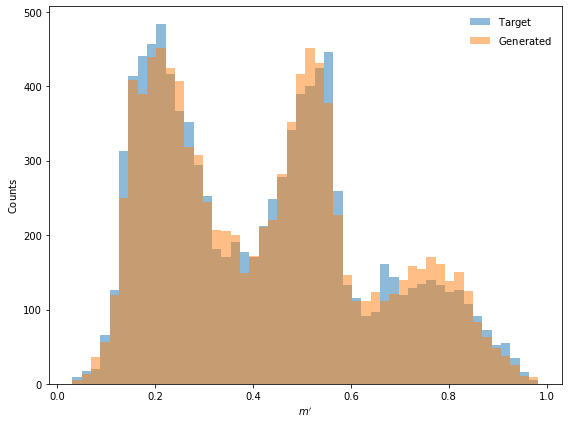

 20%|████████████▏                                                | 8/40 [34:59<2:20:19, 263.11s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 9/40: Training Loss = -1.0731, Validation Loss = -1.0798


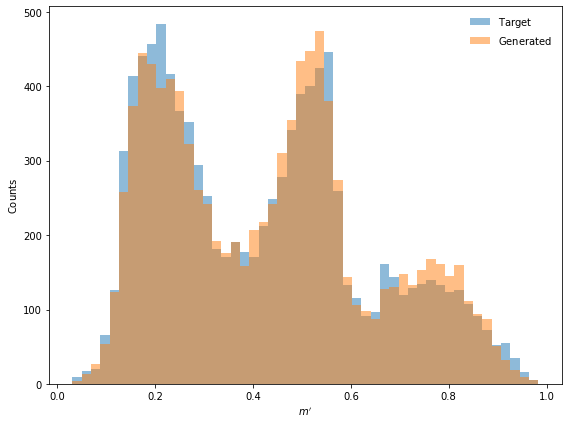

 22%|█████████████▋                                               | 9/40 [39:57<2:21:33, 273.99s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 10/40: Training Loss = -1.0783, Validation Loss = -1.0796


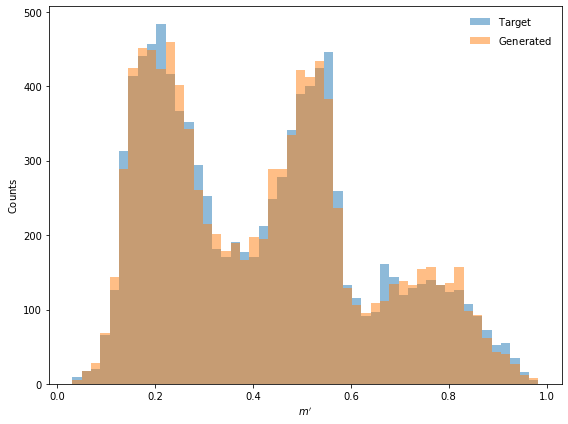

 25%|███████████████                                             | 10/40 [45:04<2:22:08, 284.29s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 11/40: Training Loss = -1.0809, Validation Loss = -1.0802


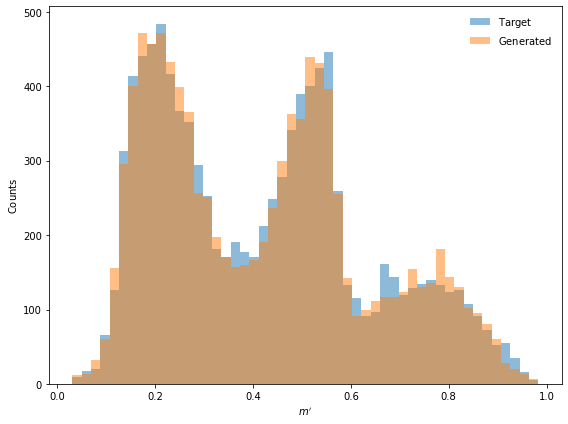

 28%|███████████████▉                                          | 11/40 [1:01:57<4:05:14, 507.41s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 12/40: Training Loss = -1.0817, Validation Loss = -1.0668


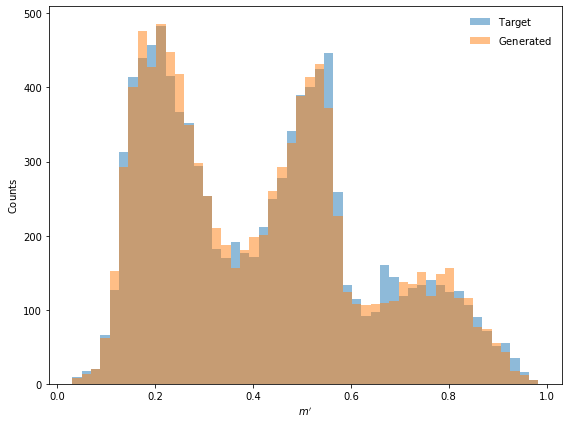

 30%|█████████████████▍                                        | 12/40 [1:06:21<3:22:07, 433.11s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 13/40: Training Loss = -1.0810, Validation Loss = -1.0828


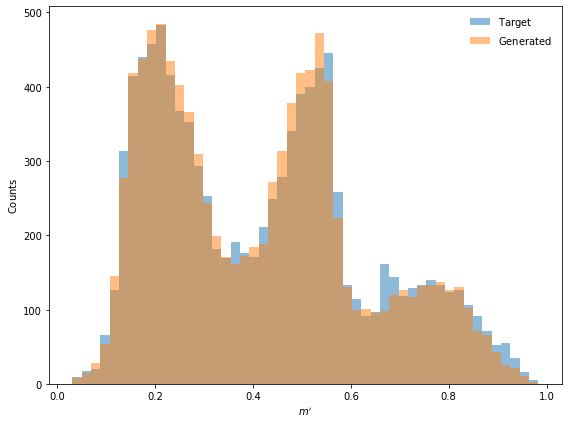

 32%|██████████████████▊                                       | 13/40 [1:10:43<2:51:35, 381.31s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 14/40: Training Loss = -1.0829, Validation Loss = -1.0758


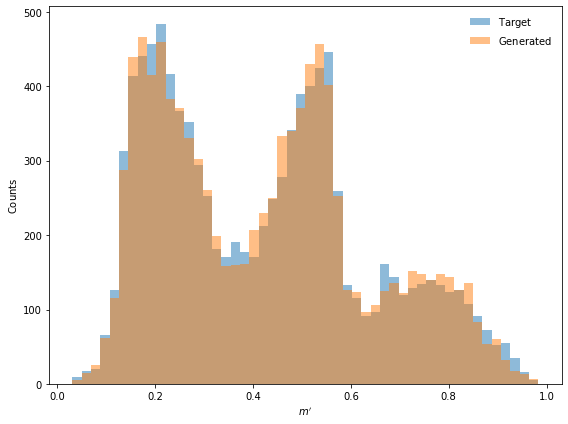

 35%|████████████████████▎                                     | 14/40 [1:15:07<2:29:51, 345.84s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 15/40: Training Loss = -1.0849, Validation Loss = -1.0819


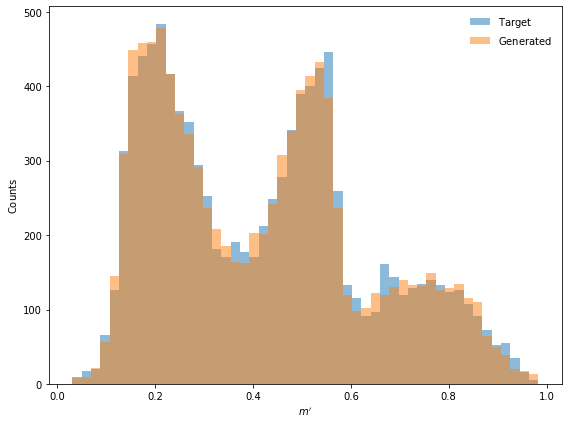

 38%|█████████████████████▊                                    | 15/40 [1:19:35<2:14:22, 322.50s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 16/40: Training Loss = -1.0857, Validation Loss = -1.0774


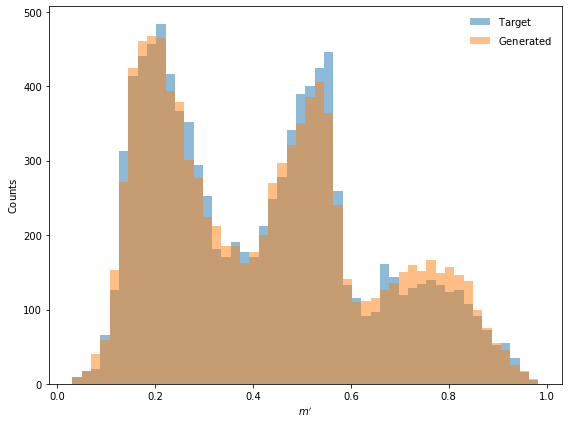

 40%|███████████████████████▏                                  | 16/40 [1:23:55<2:01:30, 303.76s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 17/40: Training Loss = -1.0881, Validation Loss = -1.1293


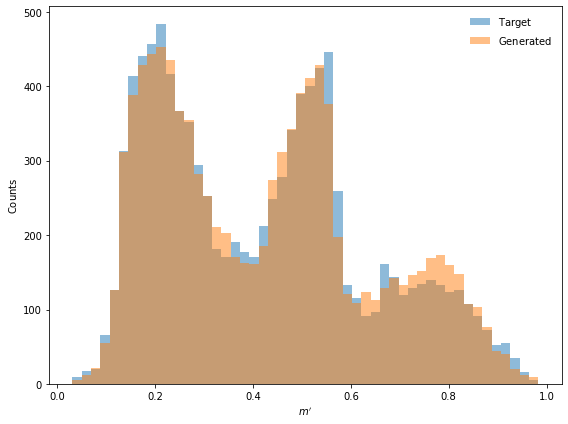

 42%|████████████████████████▋                                 | 17/40 [1:32:56<2:23:45, 375.01s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 18/40: Training Loss = -1.0854, Validation Loss = -1.0908


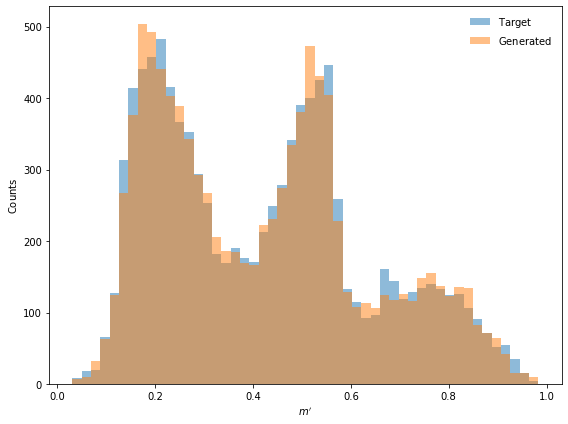

 45%|██████████████████████████                                | 18/40 [1:37:41<2:07:34, 347.92s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 19/40: Training Loss = -1.0859, Validation Loss = -1.1010


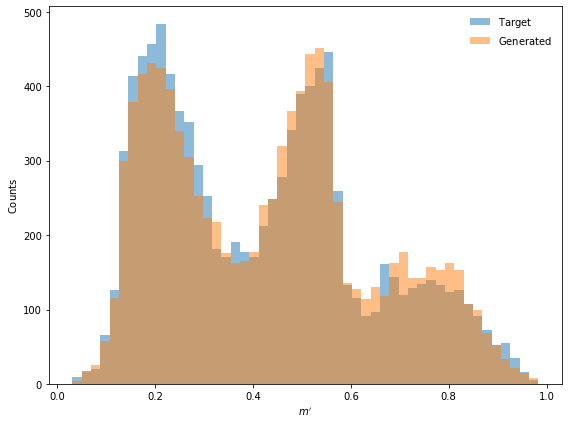

 48%|███████████████████████████▌                              | 19/40 [1:42:29<1:55:31, 330.06s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 20/40: Training Loss = -1.0888, Validation Loss = -1.0904


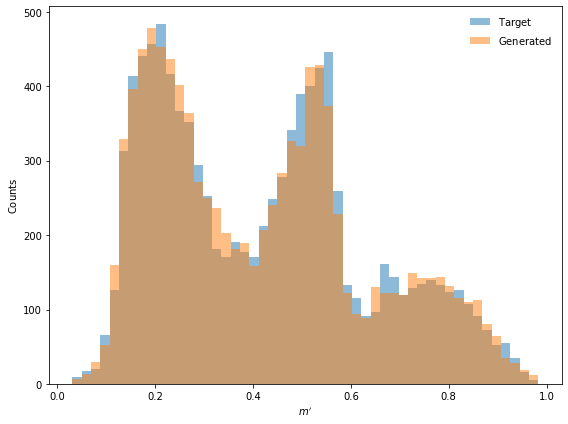

 50%|█████████████████████████████                             | 20/40 [1:47:23<1:46:25, 319.29s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 21/40: Training Loss = -1.0900, Validation Loss = -1.0650


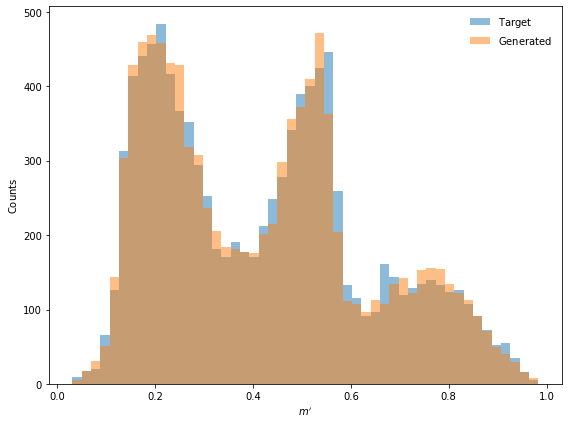

 52%|██████████████████████████████▍                           | 21/40 [1:52:12<1:38:11, 310.10s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 22/40: Training Loss = -1.0881, Validation Loss = -1.0872


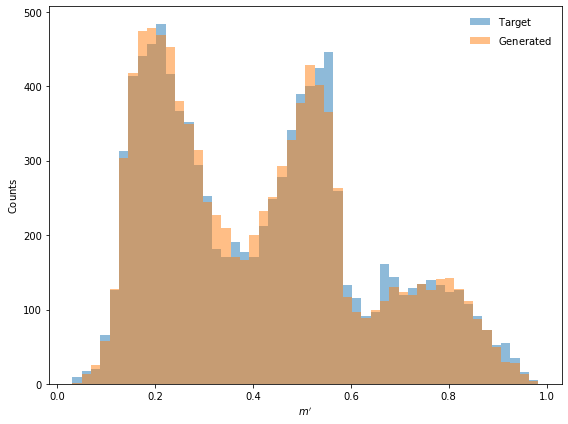

 55%|███████████████████████████████▉                          | 22/40 [1:57:05<1:31:26, 304.82s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 23/40: Training Loss = -1.0895, Validation Loss = -1.0990


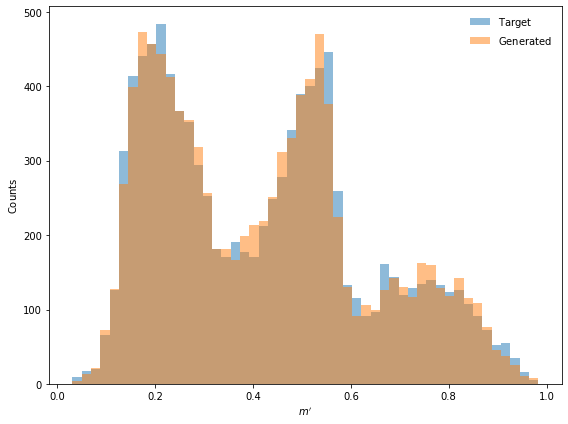

 57%|█████████████████████████████████▎                        | 23/40 [2:01:58<1:25:20, 301.22s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 24/40: Training Loss = -1.0915, Validation Loss = -1.0908


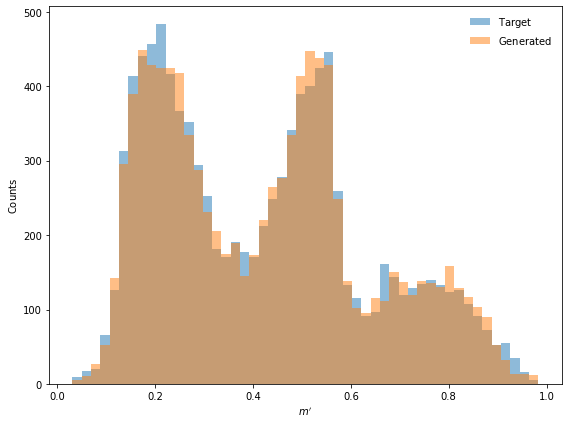

 60%|██████████████████████████████████▊                       | 24/40 [2:06:53<1:19:52, 299.54s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 25/40: Training Loss = -1.0904, Validation Loss = -1.0820


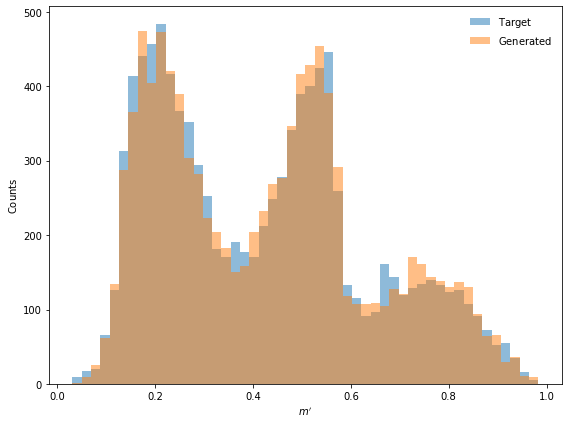

 62%|████████████████████████████████████▎                     | 25/40 [2:11:46<1:14:24, 297.66s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 26/40: Training Loss = -1.0937, Validation Loss = -1.1032


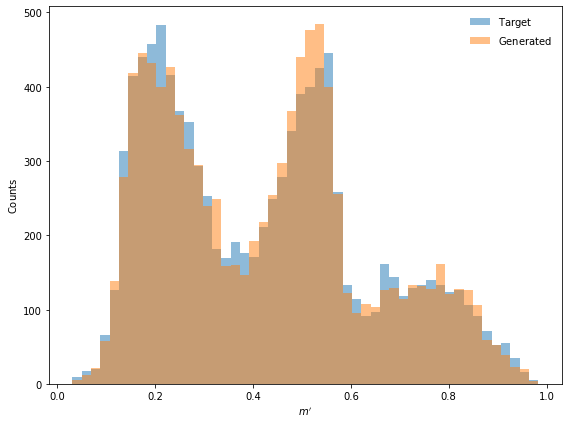

 65%|█████████████████████████████████████▋                    | 26/40 [2:16:37<1:08:56, 295.45s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 27/40: Training Loss = -1.0942, Validation Loss = -1.0954


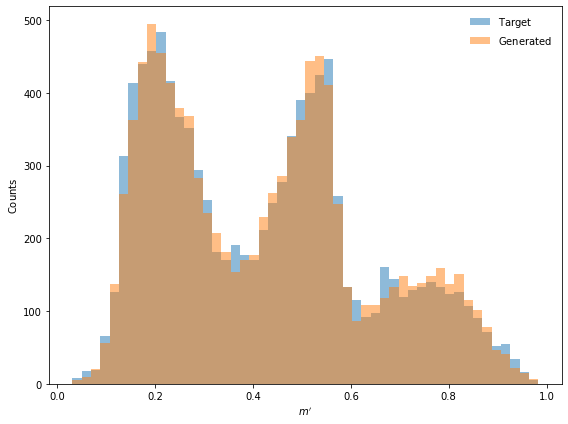

 68%|███████████████████████████████████████▏                  | 27/40 [2:21:20<1:03:12, 291.76s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 28/40: Training Loss = -1.0920, Validation Loss = -1.0782


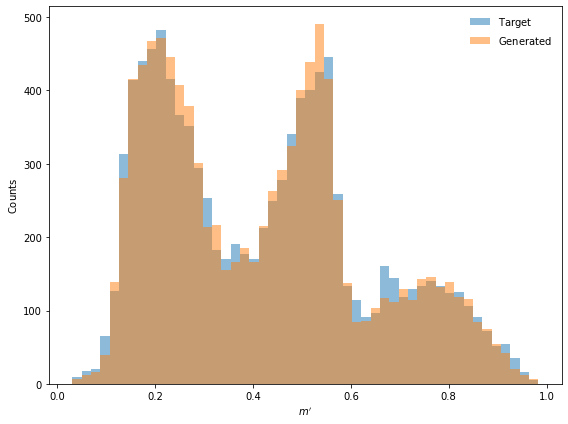

 70%|██████████████████████████████████████████                  | 28/40 [2:26:03<57:51, 289.31s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 29/40: Training Loss = -1.0939, Validation Loss = -1.0997


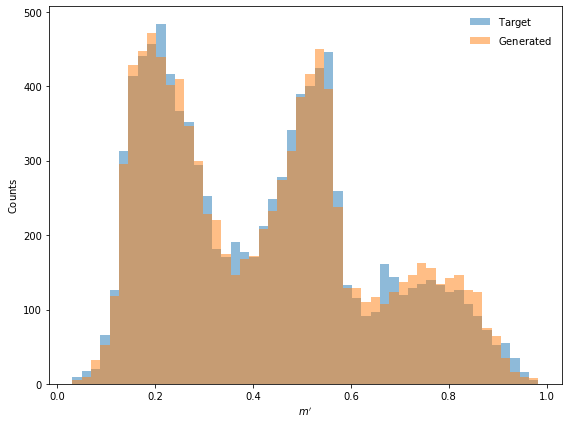

 72%|███████████████████████████████████████████▌                | 29/40 [2:30:54<53:06, 289.66s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 30/40: Training Loss = -1.0962, Validation Loss = -1.1024


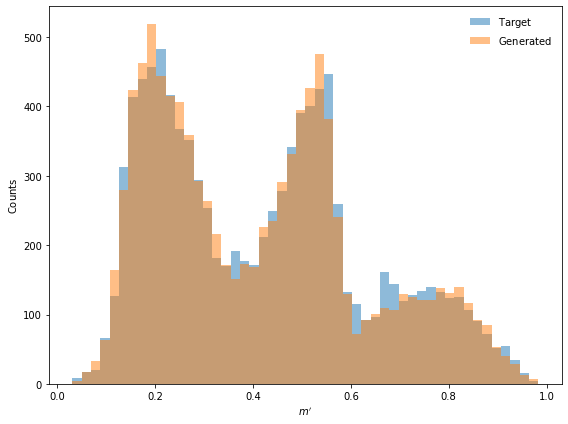

 75%|███████████████████████████████████████████▌              | 30/40 [2:46:52<1:21:41, 490.14s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 31/40: Training Loss = -1.0935, Validation Loss = -1.1017


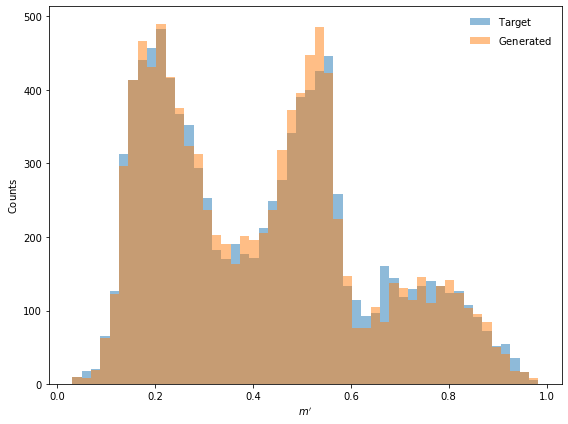

 78%|████████████████████████████████████████████▉             | 31/40 [2:57:16<1:19:33, 530.38s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 32/40: Training Loss = -1.0933, Validation Loss = -1.1176


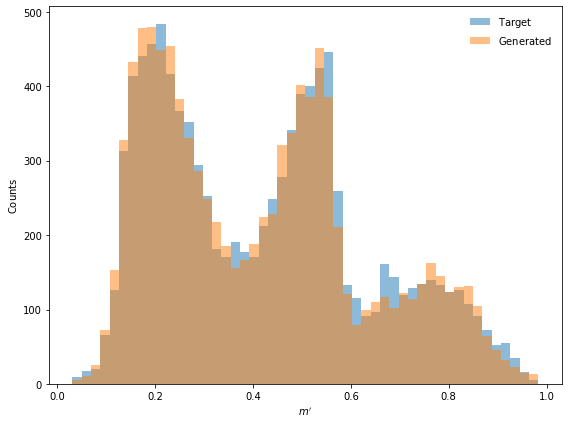

 80%|██████████████████████████████████████████████▍           | 32/40 [3:02:56<1:03:05, 473.23s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 33/40: Training Loss = -1.0955, Validation Loss = -1.0846


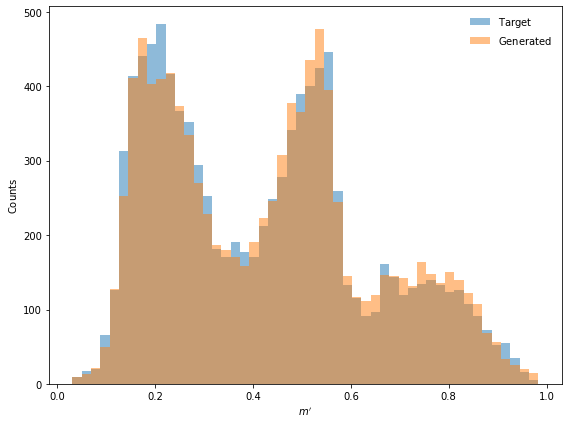

 82%|█████████████████████████████████████████████████▌          | 33/40 [3:07:54<49:04, 420.67s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 34/40: Training Loss = -1.0937, Validation Loss = -1.1009


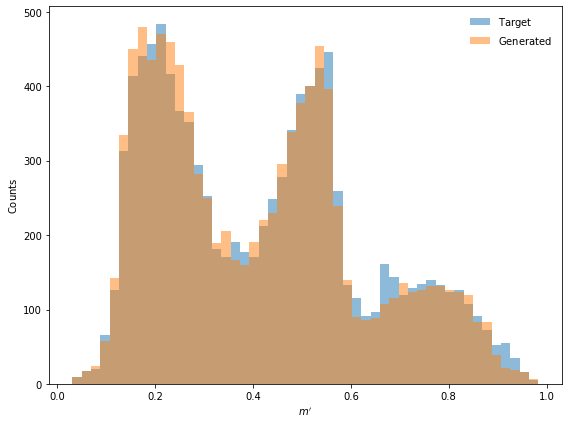

 85%|███████████████████████████████████████████████████         | 34/40 [3:12:35<37:53, 378.84s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 35/40: Training Loss = -1.0964, Validation Loss = -1.0750


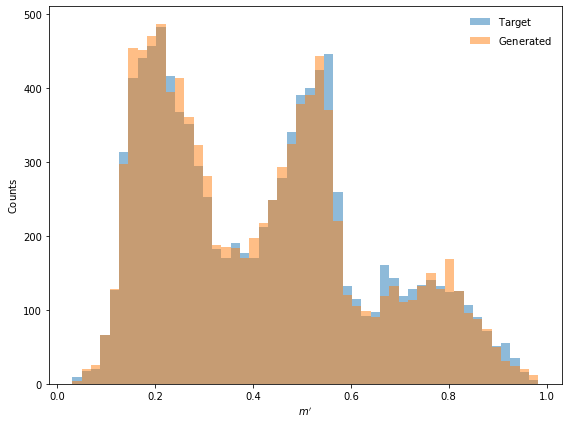

 88%|████████████████████████████████████████████████████▌       | 35/40 [3:17:15<29:05, 349.13s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 36/40: Training Loss = -1.0964, Validation Loss = -1.0875


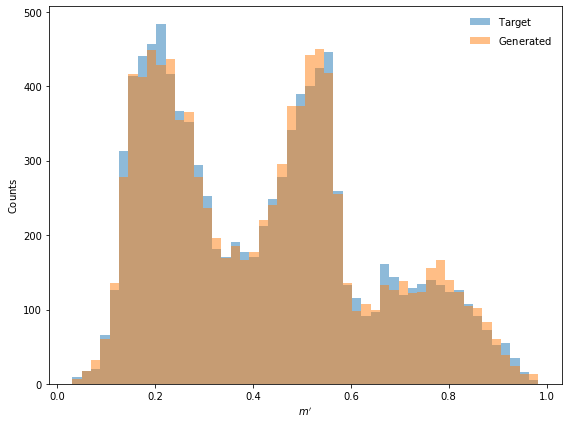

 90%|██████████████████████████████████████████████████████      | 36/40 [3:21:36<21:30, 322.53s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 37/40: Training Loss = -1.0952, Validation Loss = -1.0893


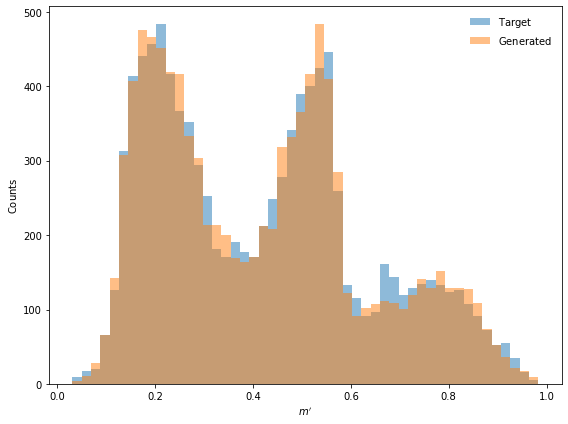

 92%|███████████████████████████████████████████████████████▌    | 37/40 [3:26:10<15:23, 307.98s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 38/40: Training Loss = -1.0944, Validation Loss = -1.0701


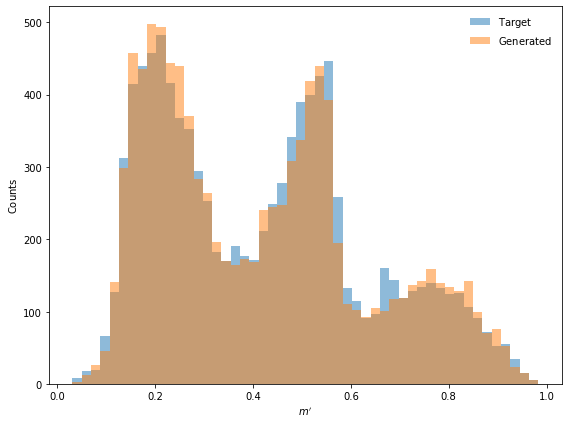

 95%|█████████████████████████████████████████████████████████   | 38/40 [3:30:46<09:56, 298.41s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable cuDNN auto-tuner for optimized performance
torch.backends.cudnn.benchmark = True

# Define the model creation function
def create_model(base='gauss'):
    K = 12  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 512, 512, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 300, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)

# Training function with mixed precision and gradient accumulation
def train(dataloader, model, optimizer, scaler, scheduler=None, accumulation_steps=1):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = -model.log_prob(batch).mean()
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    return total_loss / len(dataloader)  # Return average loss

# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new model instance
model2 = create_model(base='resampled')

# Count the number of parameters
num_params = count_parameters(model2)
print(f"Number of parameters in the model: {num_params}")

# Adjust batch size
batch_size = 20000
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 40
learning_rate = 0.0001
min_learning_rate = 1e-6
accumulation_steps = 5  # Gradient accumulation steps

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience= 1, min_lr=min_learning_rate)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Loss tracking lists for visualization
train_losses = []
val_losses = []

# Training loop with plotting
for epoch in tqdm(range(epochs), ncols=100):
    # Train the model and track loss
    train_loss = train(train_dataloader, model2, optimizer, scaler, scheduler, accumulation_steps)
    train_losses.append(train_loss)
    
    # Evaluate on validation set after each epoch
    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = val_batch.to(device)
            loss = -model2.log_prob(val_batch).mean()
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))
    
    print(f"Epoch {epoch+1}/{epochs}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss / len(val_dataloader):.4f}")
    
    # Generate samples from the trained model
    with torch.no_grad():
        samples = model2.sample(10000)
        if isinstance(samples, tuple):
            samples = samples[0]  # Extract the tensor if it's a tuple
        generated_samples = samples.cpu().numpy()

    # Visualize results
    n_samples = 10000
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot target distribution
    counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 50, alpha=0.5, label=r'$\mathrm{Target}$')

    # Plot generated samples
    ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

    ax.set_xlabel(r"$m'$")
    ax.set_ylabel(r'$\mathrm{Counts}$')
    ax.legend(loc='best', frameon=False)

    fig.tight_layout()
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.png', dpi=300, pad_inches=.1, bbox_inches='tight')

    plt.show()

# Plot the loss dynamics
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title("Training and Validation Loss Dynamics")
plt.show()


/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Number of parameters in the model: 283745


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Epoch 1/40: Training Loss = -0.8386, Validation Loss = -1.0978


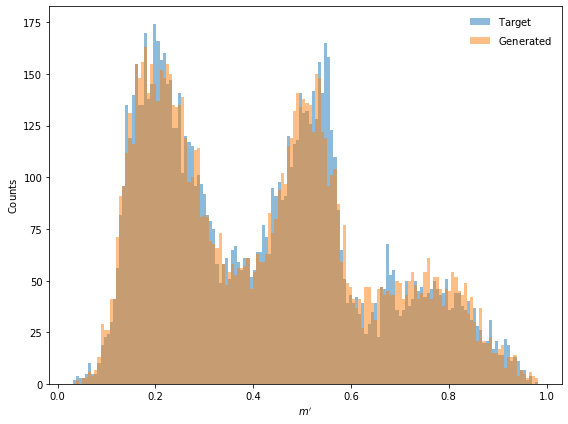

  2%|█▌                                                           | 1/40 [04:24<2:51:52, 264.42s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 2/40: Training Loss = -1.0712, Validation Loss = -1.1110


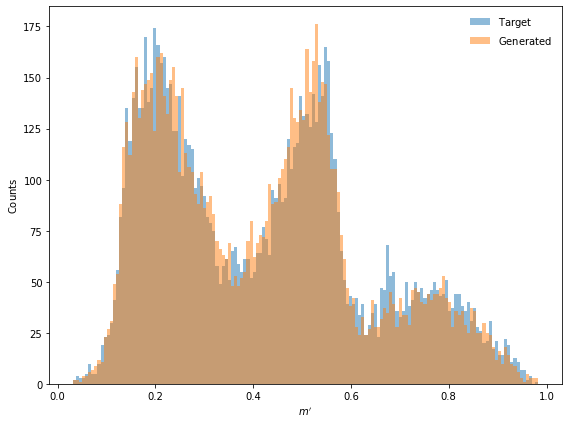

  5%|███                                                          | 2/40 [08:50<2:48:15, 265.68s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 3/40: Training Loss = -1.0831, Validation Loss = -1.0939


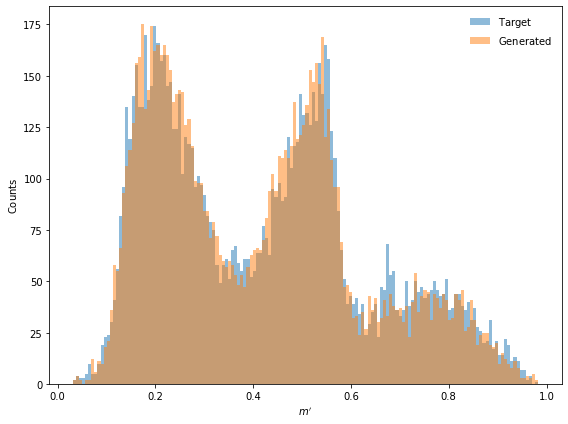

  8%|████▌                                                        | 3/40 [13:34<2:48:58, 274.01s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 4/40: Training Loss = -1.0911, Validation Loss = -0.9832


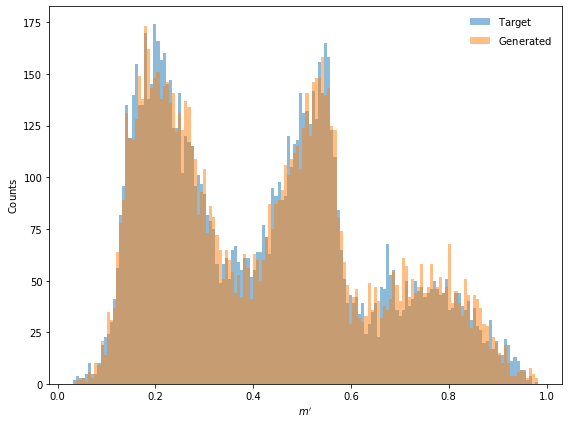

 10%|██████                                                       | 4/40 [18:19<2:46:58, 278.30s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 5/40: Training Loss = -1.0941, Validation Loss = -1.1950


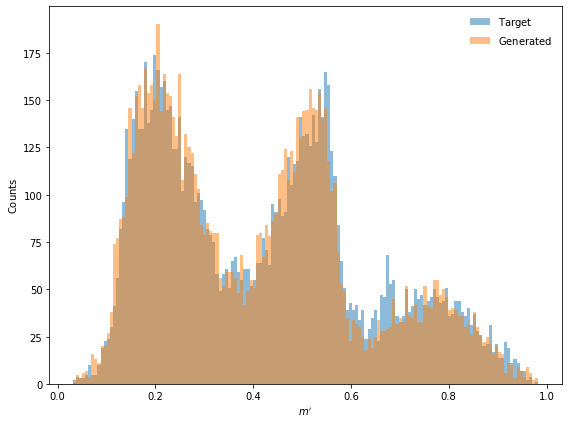

 12%|███████▋                                                     | 5/40 [23:06<2:44:05, 281.30s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 6/40: Training Loss = -1.1005, Validation Loss = -1.1331


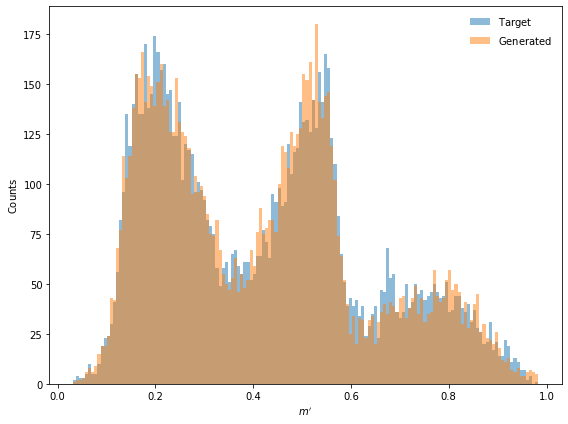

 15%|█████████▏                                                   | 6/40 [27:54<2:40:45, 283.69s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 7/40: Training Loss = -1.1009, Validation Loss = -1.2147


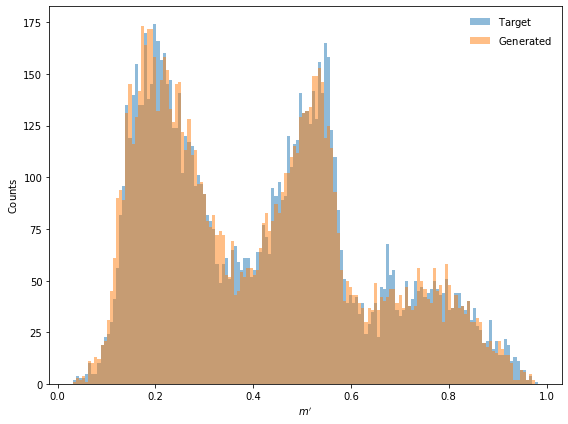

 18%|██████████▋                                                  | 7/40 [32:38<2:36:03, 283.73s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 8/40: Training Loss = -1.1023, Validation Loss = -1.0779


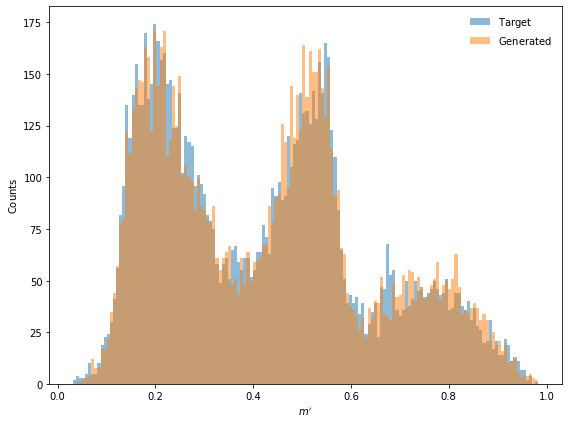

 20%|████████████▏                                                | 8/40 [37:18<2:30:45, 282.67s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 9/40: Training Loss = -1.1027, Validation Loss = -1.0219


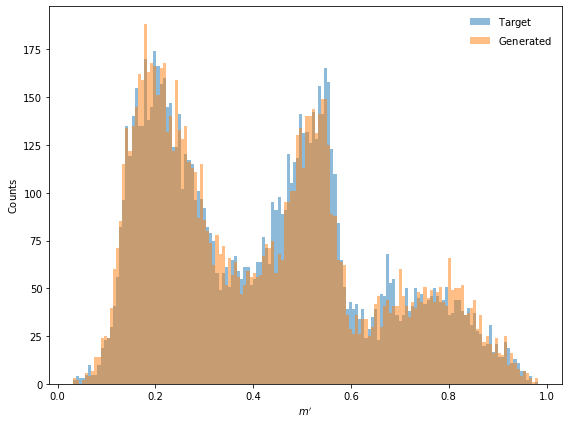

 22%|█████████████▋                                               | 9/40 [41:54<2:24:56, 280.52s/it]/Users/san/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
 22%|█████████████▋                                               | 9/40 [44:40<2:33:53, 297.85s/it]


KeyboardInterrupt: 

In [2]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable cuDNN auto-tuner for optimized performance
torch.backends.cudnn.benchmark = True

# Define the model creation function
def create_model(base='gauss'):
    K = 16  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 512, 512, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 300, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)

# Training function with mixed precision and gradient accumulation
def train(dataloader, model, optimizer, scaler, scheduler=None, accumulation_steps=1):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = -model.log_prob(batch).mean()
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    return total_loss / len(dataloader)  # Return average loss

# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new model instance
model2 = create_model(base='resampled')

# Count the number of parameters
num_params = count_parameters(model2)
print(f"Number of parameters in the model: {num_params}")

# Adjust batch size
batch_size = 20000
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 40
learning_rate = 0.001
min_learning_rate = 1e-7
accumulation_steps = 5  # Gradient accumulation steps

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience= 1, min_lr=min_learning_rate)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Loss tracking lists for visualization
train_losses = []
val_losses = []

# Training loop with plotting
for epoch in tqdm(range(epochs), ncols=100):
    # Train the model and track loss
    train_loss = train(train_dataloader, model2, optimizer, scaler, scheduler, accumulation_steps)
    train_losses.append(train_loss)
    
    # Evaluate on validation set after each epoch
    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = val_batch.to(device)
            loss = -model2.log_prob(val_batch).mean()
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))
    
    print(f"Epoch {epoch+1}/{epochs}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss / len(val_dataloader):.4f}")
    
    # Generate samples from the trained model
    with torch.no_grad():
        samples = model2.sample(10000)
        if isinstance(samples, tuple):
            samples = samples[0]  # Extract the tensor if it's a tuple
        generated_samples = samples.cpu().numpy()

    # Visualize results
    n_samples = 10000
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot target distribution
    counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 150, alpha=0.5, label=r'$\mathrm{Target}$')

    # Plot generated samples
    ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

    ax.set_xlabel(r"$m'$")
    ax.set_ylabel(r'$\mathrm{Counts}$')
    ax.legend(loc='best', frameon=False)

    fig.tight_layout()
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
    fig.savefig(f'figs/D-amplitude_SDP_mp_INN_target_vs_gen_epoch_{epoch+1}.png', dpi=300, pad_inches=.1, bbox_inches='tight')

    plt.show()

# Plot the loss dynamics
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title("Training and Validation Loss Dynamics")
plt.show()
